# Data Analyst Test Task

In order to apply for the data scientist position in **Company**, please find some time to solve **at least one** of the tasks below. The tasks shed some light at the problems that need solving by a data scientist.


It is likely that the exact formulation of the task nor the domain that the data originates from might never be part of the actual everyday work in STACC. Rather, the tasks are designed in a way to get the best understanding of the applicant's strengths and weaknesses. Also, to understand how the applicant solves different problems and what are the values held high in doing so.


*Please note that while solving every single subtask exemplary is to be applauded at and increases the likelihood of getting chosen, it's the quality and insights that triumph over quantity. If you are running low on time, don't feel bad in sending half-finished assignment if you yourself are at least semi-proud of it.*

## What will be assessed?

1. The way the problems are approached.
2. The way the solution is organized.
3. The way the best practices in code and Notebook are addressed.
4. The reproducability of the analysis.
5. The achieved results and conclusions made on the said results.
6. The appearance of the Notebook.
7. The visualizations in terms of plots and tables.
8. The way your work is explained and commented.

## Data Description

The energy production data was retrieved from https://transparency.entsoe.eu/ <br> 
and Nord Pool power market price data from https://dashboard.elering.ee/en/nps/price.

#### 1. Contents of est_electricity_prod_2021_2022_test_task.parquet:

| Column Name                     | Data type                      | Notes                                      | Unit |
|---------------------------------|--------------------------------|--------------------------------------------|------|
| date                            | datetime64[ns, Europe/Tallinn] | Date of energy production                  |      |
| Biomass                         | float64                        | Amount of Biomass produced                 | MW   |
| Fossil Coal-derived gas         | float64                        | Amount of Fossil Coal-derived gas produced | MW   |
| Fossil Gas                      | float64                        | Amount of Fossil Gas produced              | MW   |
| Fossil Oil shale                | float64                        | Same pattern all the way down this list :) | MW   |
| Fossil Peat                     | float64                        | ...                                        | MW   |
| Hydro Run-of-river and poundage | float64                        | ...                                        | MW   |
| Other                           | float64                        | ...                                        | MW   |
| Other renewable                 | float64                        | ...                                        | MW   |
| Solar                           | float64                        | ...                                        | MW   |
| Waste                           | float64                        | ...                                        | MW   |
| Wind_Onshore                    | float64                        | ...                                        | MW   |


#### 2. Contents of nps_2021_2022_test_task.parquet

| COLUMN          | type   | unit               |
|-----------------|--------|--------------------|
| Timestamp (UTC) | int64  | Unix timestamp (s) |
| NPS Latvia      | object | €/MW/h             |
| NPS Lithuania   | object | €/MW/h             |
| NPS Finland     | object | €/MW/h             |
| NPS Estonia     | object | €/MW/h             |

## Technical Requirements

Choice of libraries is up to you! We only require Python >= 3.8. 

With the solution please provide a "requirements.txt" file that states the version of Python and the used libraries. Alternatively, you can specify these requirements in the first cell of your notebook. In case the requirements are not provided, we will assume that the code works with our chosen versions without any additional debugging. 

Send the solution as a *.ipynb or *.zip file, Bitbucket/GitHub repository or your favourite cloud disk (e.g. Google Drive) link. 

## Task 1. BI Analytics

### Task Description

Provide a BI analytics report, which should include following points:

- Data quality assesment.
- Overview of the data.
- Compare different energy production types and find any important temporal patterns.
- Find the energy production types that are most stable and most hectic across one year.
- Find if there exist any clear correlations or patterns between production type/volume and Nord Pool price.
- Find arguments for or against whether renewable energy production increases Nord Pool price.
- Find whether there are stronger hourly or weekly trends in terms of both energy production and price.
- Provide any additional analytics that you see fit.

In [1]:
!python -V

Python 3.10.9


In [2]:
# Task 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Task 2
from sklearn import datasets
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [3]:
energy_prod =  pd.read_parquet('est_electricity_prod_2021_2022_test_task.parquet', engine='pyarrow')
market_price = pd.read_parquet('nps_2021_2022_test_task.parquet', engine='pyarrow')

In [4]:
market_price

Timestamp (UTC) NPS Latvia NPS Lithuania NPS Finland NPS Estonia
0           1640988000      57,98         57,98       29,76       57,98
1           1640991600      50,05         50,05        46,6       50,05
2           1640995200      41,33         41,33       41,33       41,33
3           1640998800      42,18         42,18       42,18       42,18
4           1641002400      44,37         44,37       44,37       44,37
...                ...        ...           ...         ...         ...
17515       1640970000      99,99         99,99       98,21       99,99
17516       1640973600      92,66         92,66       73,98       92,66
17517       1640977200         92            92       33,96          92
17518       1640980800      78,03         78,03       51,03       78,03
17519       1640984400       69,7          69,7       35,15        69,7

[17520 rows x 5 columns]

#### Subtasks 1 and 2

**- Data quality assessment.**
**- Overview of the data.**

At this stage, we observe that data was correctly loaded to the notebook with all formats corresponding to the description file. However, there is a number of missing values in all the variables but `date`. The easiest and the most efficient way is to remove the NAs since they compile less than 1 percent (0.08%)  of overall data; thus, removing them will not affect the overall quality of the data.

In [5]:
print(energy_prod.info())
print(energy_prod.isna().sum())
print(energy_prod.isna().sum()/len(energy_prod) * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17496 entries, 0 to 17495
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype                         
---  ------                           --------------  -----                         
 0   date                             17496 non-null  datetime64[ns, Europe/Tallinn]
 1   Biomass                          17481 non-null  float64                       
 2   Fossil Coal-derived gas          17481 non-null  float64                       
 3   Fossil Gas                       17481 non-null  float64                       
 4   Fossil Oil shale                 17481 non-null  float64                       
 5   Fossil Peat                      17481 non-null  float64                       
 6   Hydro Run-of-river and poundage  17481 non-null  float64                       
 7   Other                            17481 non-null  float64                       
 8   Other renewable                  174

In [6]:
energy_prod = energy_prod.dropna()
print(energy_prod.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17481 entries, 0 to 17495
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype                         
---  ------                           --------------  -----                         
 0   date                             17481 non-null  datetime64[ns, Europe/Tallinn]
 1   Biomass                          17481 non-null  float64                       
 2   Fossil Coal-derived gas          17481 non-null  float64                       
 3   Fossil Gas                       17481 non-null  float64                       
 4   Fossil Oil shale                 17481 non-null  float64                       
 5   Fossil Peat                      17481 non-null  float64                       
 6   Hydro Run-of-river and poundage  17481 non-null  float64                       
 7   Other                            17481 non-null  float64                       
 8   Other renewable                  174

Another stylistic change is changing the variable names format to lower case and replacing space with the lower dash. For that I will write a function, which I then later use on both datasets.

In [7]:
def col_names_formatting(df):
    format_col = df.columns
    format_col = [i.lower().replace('°', '').replace('/', '_').replace('-', '_').replace(' ', '_')  for i in format_col]
    return format_col

In [8]:
energy_prod.columns = col_names_formatting(energy_prod)
energy_prod.columns

Index(['date', 'biomass', 'fossil_coal_derived_gas', 'fossil_gas',
       'fossil_oil_shale', 'fossil_peat', 'hydro_run_of_river_and_poundage',
       'other', 'other_renewable', 'solar', 'waste', 'wind_onshore'],
      dtype='object')

In comparison to the production dataset, the file with market prices does not have any missing values but has more observations (17520) than the production file (17481). But I am confused why price values are in string format, so I will convert those to float.

In [9]:
print(market_price.info())
print(market_price.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Timestamp (UTC)  17520 non-null  int64 
 1   NPS Latvia       17520 non-null  object
 2   NPS Lithuania    17520 non-null  object
 3   NPS Finland      17520 non-null  object
 4   NPS Estonia      17520 non-null  object
dtypes: int64(1), object(4)
memory usage: 684.5+ KB
None
Timestamp (UTC)    0
NPS Latvia         0
NPS Lithuania      0
NPS Finland        0
NPS Estonia        0
dtype: int64


In [10]:
for col in market_price.columns[1:]:
    market_price[col] = pd.to_numeric(market_price[col].str.replace(',','.'), errors='coerce')

Another necessary transformation is about the format of the timestamp, which I should make the same as the date in the `production` dataset so later I could merge the files into one. I am more than sure that I did it inefficiently, but I thought that it was crucial to keep the Estonian timezone because the analysis revolves around Estonia. That is why I converted the timestamp from the `market_price` dataset to datetime64 with Tallinn's timezone*.

Also, I changed the name of the `timestamp (utc)` because it is inconvenient to carry such a name around. But before that, I also changed the format of the variables' titles in the dataset.

\* I am not sure how I properly addressed the daylight savings in Estonia under the parameter `ambiguous`, so if I got a chance, I would like to get instruction on how to deal with datetime objects.

In [11]:
market_price.columns = col_names_formatting(market_price)

In [12]:
market_price

timestamp_(utc)  nps_latvia  nps_lithuania  nps_finland  nps_estonia
0           1640988000       57.98          57.98        29.76        57.98
1           1640991600       50.05          50.05        46.60        50.05
2           1640995200       41.33          41.33        41.33        41.33
3           1640998800       42.18          42.18        42.18        42.18
4           1641002400       44.37          44.37        44.37        44.37
...                ...         ...            ...          ...          ...
17515       1640970000       99.99          99.99        98.21        99.99
17516       1640973600       92.66          92.66        73.98        92.66
17517       1640977200       92.00          92.00        33.96        92.00
17518       1640980800       78.03          78.03        51.03        78.03
17519       1640984400       69.70          69.70        35.15        69.70

[17520 rows x 5 columns]

In [13]:
market_price.rename(columns={'timestamp_(utc)': 'date'}, inplace=True)

In [14]:
market_price['date'] = [datetime.fromtimestamp(i) for i in market_price['date']]

In [15]:
import pytz
tz_estonia = pytz.timezone('Europe/Tallinn')

In [16]:
market_price['date'] = [tz_estonia.localize(market_price['date'][i]) for i in range(len(market_price))]

Here I merge the production and price files on `date` for the sake of convenience!

In [17]:
df = pd.merge(market_price, energy_prod, on='date')
df = df.sort_values(by='date').reset_index().drop('index', axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17481 entries, 0 to 17480
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype                         
---  ------                           --------------  -----                         
 0   date                             17481 non-null  datetime64[ns, Europe/Tallinn]
 1   nps_latvia                       17481 non-null  float64                       
 2   nps_lithuania                    17481 non-null  float64                       
 3   nps_finland                      17481 non-null  float64                       
 4   nps_estonia                      17481 non-null  float64                       
 5   biomass                          17481 non-null  float64                       
 6   fossil_coal_derived_gas          17481 non-null  float64                       
 7   fossil_gas                       17481 non-null  float64                       
 8   fossil_oil_shale                 174

In [19]:
df

date  nps_latvia  nps_lithuania  nps_finland  \
0     2021-01-01 00:00:00+02:00       24.07          24.07        24.07   
1     2021-01-01 01:00:00+02:00       24.95          24.95        24.95   
2     2021-01-01 02:00:00+02:00       24.35          24.35        24.35   
3     2021-01-01 03:00:00+02:00       23.98          23.98        23.98   
4     2021-01-01 04:00:00+02:00       23.72          23.72        23.72   
...                         ...         ...            ...          ...   
17476 2022-12-30 19:00:00+02:00       95.06          95.06        27.92   
17477 2022-12-30 20:00:00+02:00      102.18         102.18        24.97   
17478 2022-12-30 21:00:00+02:00       95.09          95.09        19.88   
17479 2022-12-30 22:00:00+02:00       45.02          45.02        18.35   
17480 2022-12-30 23:00:00+02:00       10.06          10.06         4.27   

       nps_estonia  biomass  fossil_coal_derived_gas  fossil_gas  \
0            24.07     71.0                     26.0         2.0   
1            24.95     70.0                     26.0         2.0   
2            24.35     69.0                     27.0         2.0   
3            23.98     69.0                     26.0         2.0   
4            23.72     66.0                     24.0         2.0   
...            ...      ...                      ...         ...   
17476        95.06     54.0                     62.0         6.0   
17477       102.18     53.0                     62.0         7.0   
17478        95.09     55.0                     62.0         7.0   
17479        45.02     50.0                     62.0         7.0   
17480        10.06     46.0                     62.0         6.0   

       fossil_oil_shale  fossil_peat  hydro_run_of_river_and_poundage  other  \
0                 150.0          3.0                              1.0    0.0   
1                 156.0          3.0                              1.0    0.0   
2                 119.0          3.0                              1.0    0.0   
3                 123.0          3.0                              1.0    0.0   
4                 121.0          3.0                              1.0    0.0   
...                 ...          ...                              ...    ...   
17476             257.0          0.0                              0.0    0.0   
17477             264.0          0.0                              0.0    0.0   
17478             255.0          0.0                              0.0    0.0   
17479             255.0          0.0                              0.0    0.0   
17480             254.0          0.0                              0.0    0.0   

       other_renewable  solar  waste  wind_onshore  
0                  4.0    0.0   16.0          36.0  
1                  4.0    0.0   16.0          29.0  
2                  4.0    0.0   15.0          29.0  
3                  4.0    0.0   16.0          25.0  
4                  4.0    0.0   15.0          20.0  
...                ...    ...    ...           ...  
17476              1.0    0.0   18.0          96.0  
17477              1.0    0.0   18.0          95.0  
17478              1.0    0.0   18.0          97.0  
17479              1.0    0.0   18.0          94.0  
17480              1.0    0.0   18.0         116.0  

[17481 rows x 16 columns]

Our final dataset lost another dozen of observations because here I chose the `inner` join, which matches all records from the left table to the observation in the right only if they exist in both tables, without adding missing data.

The last step is to check the final dataset for outliers, so they would not affect the visualization and analysis! I did it not with calculation of interquartile range, but more straightforwardly, by providing descriptive statistics and counting unique values where it seems suspicious. I do it for all values because they might be used later in the analysis.

Since prices for Latvia, Lithuania, and Estonia have an extremely high max value of 4000, I count values just for them. Additionally, the `other` variable is empty, so I will drop it.

In [20]:
print(df.describe())
print(df[['nps_latvia', 'nps_lithuania', 'nps_estonia']].value_counts().sort_index(ascending=False))
df = df.drop('other', axis=1)

         nps_latvia  nps_lithuania   nps_finland   nps_estonia       biomass  \
count  17481.000000   17481.000000  17481.000000  17481.000000  17481.000000   
mean     158.064636     160.544920    113.358016    139.956505     95.704193   
std      137.170876     138.972086    112.320052    119.761934     78.125691   
min       -1.410000      -1.410000     -2.080000     -1.410000      1.000000   
25%       66.290000      67.300000     39.440000     62.270000     52.000000   
50%      111.120000     111.940000     77.080000    103.000000     71.000000   
75%      208.010000     211.830000    149.900000    183.060000     90.000000   
max     4000.000000    4000.000000   1000.070000   4000.000000    409.000000   

       fossil_coal_derived_gas    fossil_gas  fossil_oil_shale   fossil_peat  \
count             17481.000000  17481.000000      17481.000000  17481.000000   
mean                 44.229106      3.169613        449.663063      1.565471   
std                  13.177262      1.7

According to the analysis, there is outliers of 4000 and 2100, which should be omitted.

In [21]:
df = df[(df.nps_estonia != 4000) & (df.nps_latvia != 4000) & (df.nps_lithuania != 4000)]
df = df[(df.nps_lithuania != 2100.08) & (df.nps_latvia != 2100.08)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17479 entries, 0 to 17480
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype                         
---  ------                           --------------  -----                         
 0   date                             17479 non-null  datetime64[ns, Europe/Tallinn]
 1   nps_latvia                       17479 non-null  float64                       
 2   nps_lithuania                    17479 non-null  float64                       
 3   nps_finland                      17479 non-null  float64                       
 4   nps_estonia                      17479 non-null  float64                       
 5   biomass                          17479 non-null  float64                       
 6   fossil_coal_derived_gas          17479 non-null  float64                       
 7   fossil_gas                       17479 non-null  float64                       
 8   fossil_oil_shale                 174

Now our data does not have any missing values, the formats are adequate (prices are numbers, production sizes are also numbers, and my only pain is the `date`, which is in the Estonian timezone but still timestamps). The data does not have outliers, and everything is stored in one file.


In [22]:
df.head()

date  nps_latvia  nps_lithuania  nps_finland  \
0 2021-01-01 00:00:00+02:00       24.07          24.07        24.07   
1 2021-01-01 01:00:00+02:00       24.95          24.95        24.95   
2 2021-01-01 02:00:00+02:00       24.35          24.35        24.35   
3 2021-01-01 03:00:00+02:00       23.98          23.98        23.98   
4 2021-01-01 04:00:00+02:00       23.72          23.72        23.72   

   nps_estonia  biomass  fossil_coal_derived_gas  fossil_gas  \
0        24.07     71.0                     26.0         2.0   
1        24.95     70.0                     26.0         2.0   
2        24.35     69.0                     27.0         2.0   
3        23.98     69.0                     26.0         2.0   
4        23.72     66.0                     24.0         2.0   

   fossil_oil_shale  fossil_peat  hydro_run_of_river_and_poundage  \
0             150.0          3.0                              1.0   
1             156.0          3.0                              1.0   
2             119.0          3.0                              1.0   
3             123.0          3.0                              1.0   
4             121.0          3.0                              1.0   

   other_renewable  solar  waste  wind_onshore  
0              4.0    0.0   16.0          36.0  
1              4.0    0.0   16.0          29.0  
2              4.0    0.0   15.0          29.0  
3              4.0    0.0   16.0          25.0  
4              4.0    0.0   15.0          20.0

#### Subtask 3
**- Compare different energy production types and find any important temporal patterns.**

At this stage of analysis, I decided to compare the production types next to each other instead of separate plots for each one.

In order not to carry all the lengthy variables' names, I created two dictionaries, which I later used to create several charts on one figure.

In [23]:
dic_fossil = {'Fossil Coal Gas':'fossil_coal_derived_gas',
              'Fossil Gas':'fossil_gas',
              'Fossil Oil':'fossil_oil_shale',
              'Fossil Peat':'fossil_peat'}

dic_renewable = {'Hydro':'hydro_run_of_river_and_poundage',
              'Bioamss':'biomass',
              'Other Renrewable':'other_renewable',
              'Solar':'solar',
              'Waste':'waste',
              'Wind':'wind_onshore'}

Text(0.5, 1.02, 'They are minerals! Oh, I meant fossil...\nscatterplots on hourly fossil-related production throughout years 2021 and 2022')

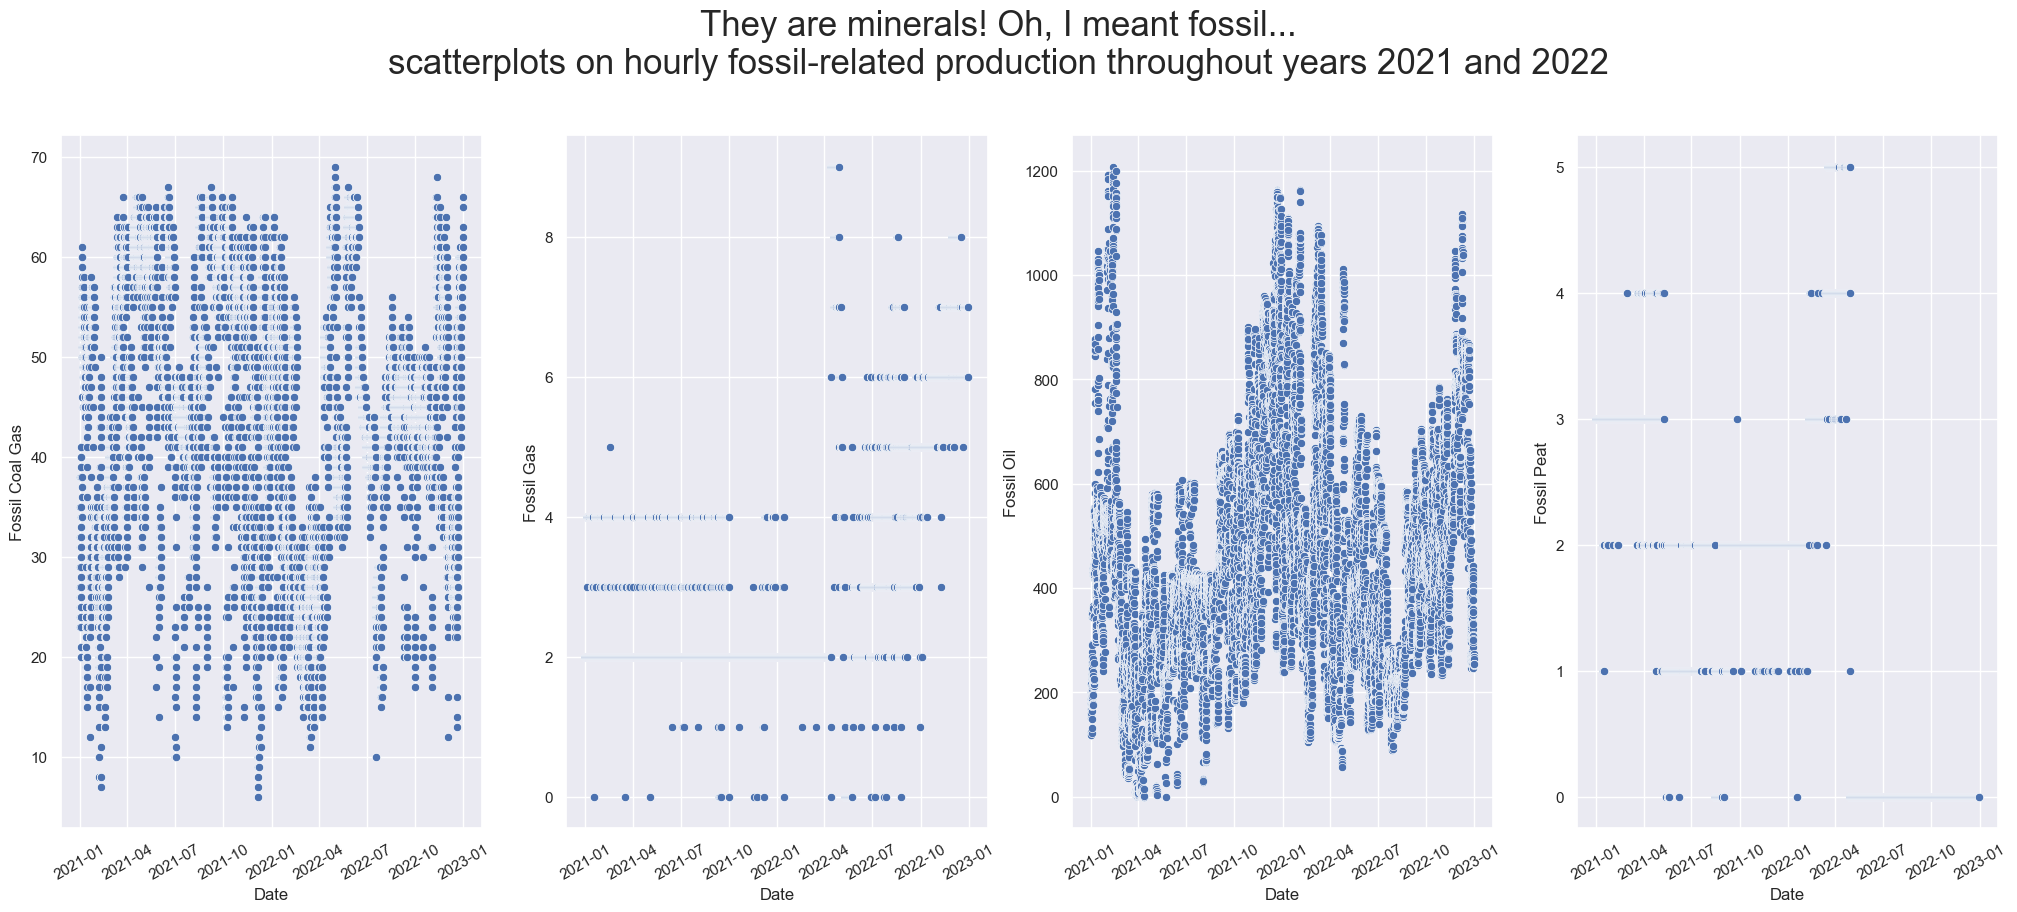

In [24]:
fig, axs = plt.subplots(ncols=4)
fig.set_figheight(9)
fig.set_figwidth(25)

for i, item in enumerate(dic_fossil.items()):
    g = sns.scatterplot(data=df,
                        x=df.date,
                        y=item[1],
                        ax=axs[i])
    axs[i].set(xlabel = 'Date',
           ylabel= item[0])

    g.set_xticklabels(g.get_xticklabels(), rotation=30)

fig.suptitle(f'They are minerals! Oh, I meant fossil...{os.linesep}'
             f'scatterplots on hourly fossil-related production throughout years 2021 and 2022', y=1.02, fontsize=25)

The intermediate result for the fossil-related production types is that Fossil Oil consumption depends on seasonality: more electricity is produced during winters and less in warmer seasons.

Text(0.5, 1.02, 'Five Elements: Water, Fire, Earth, Wind, and Trash \nscatterplots on hourly renewable types production throughout years 2021 and 2022')

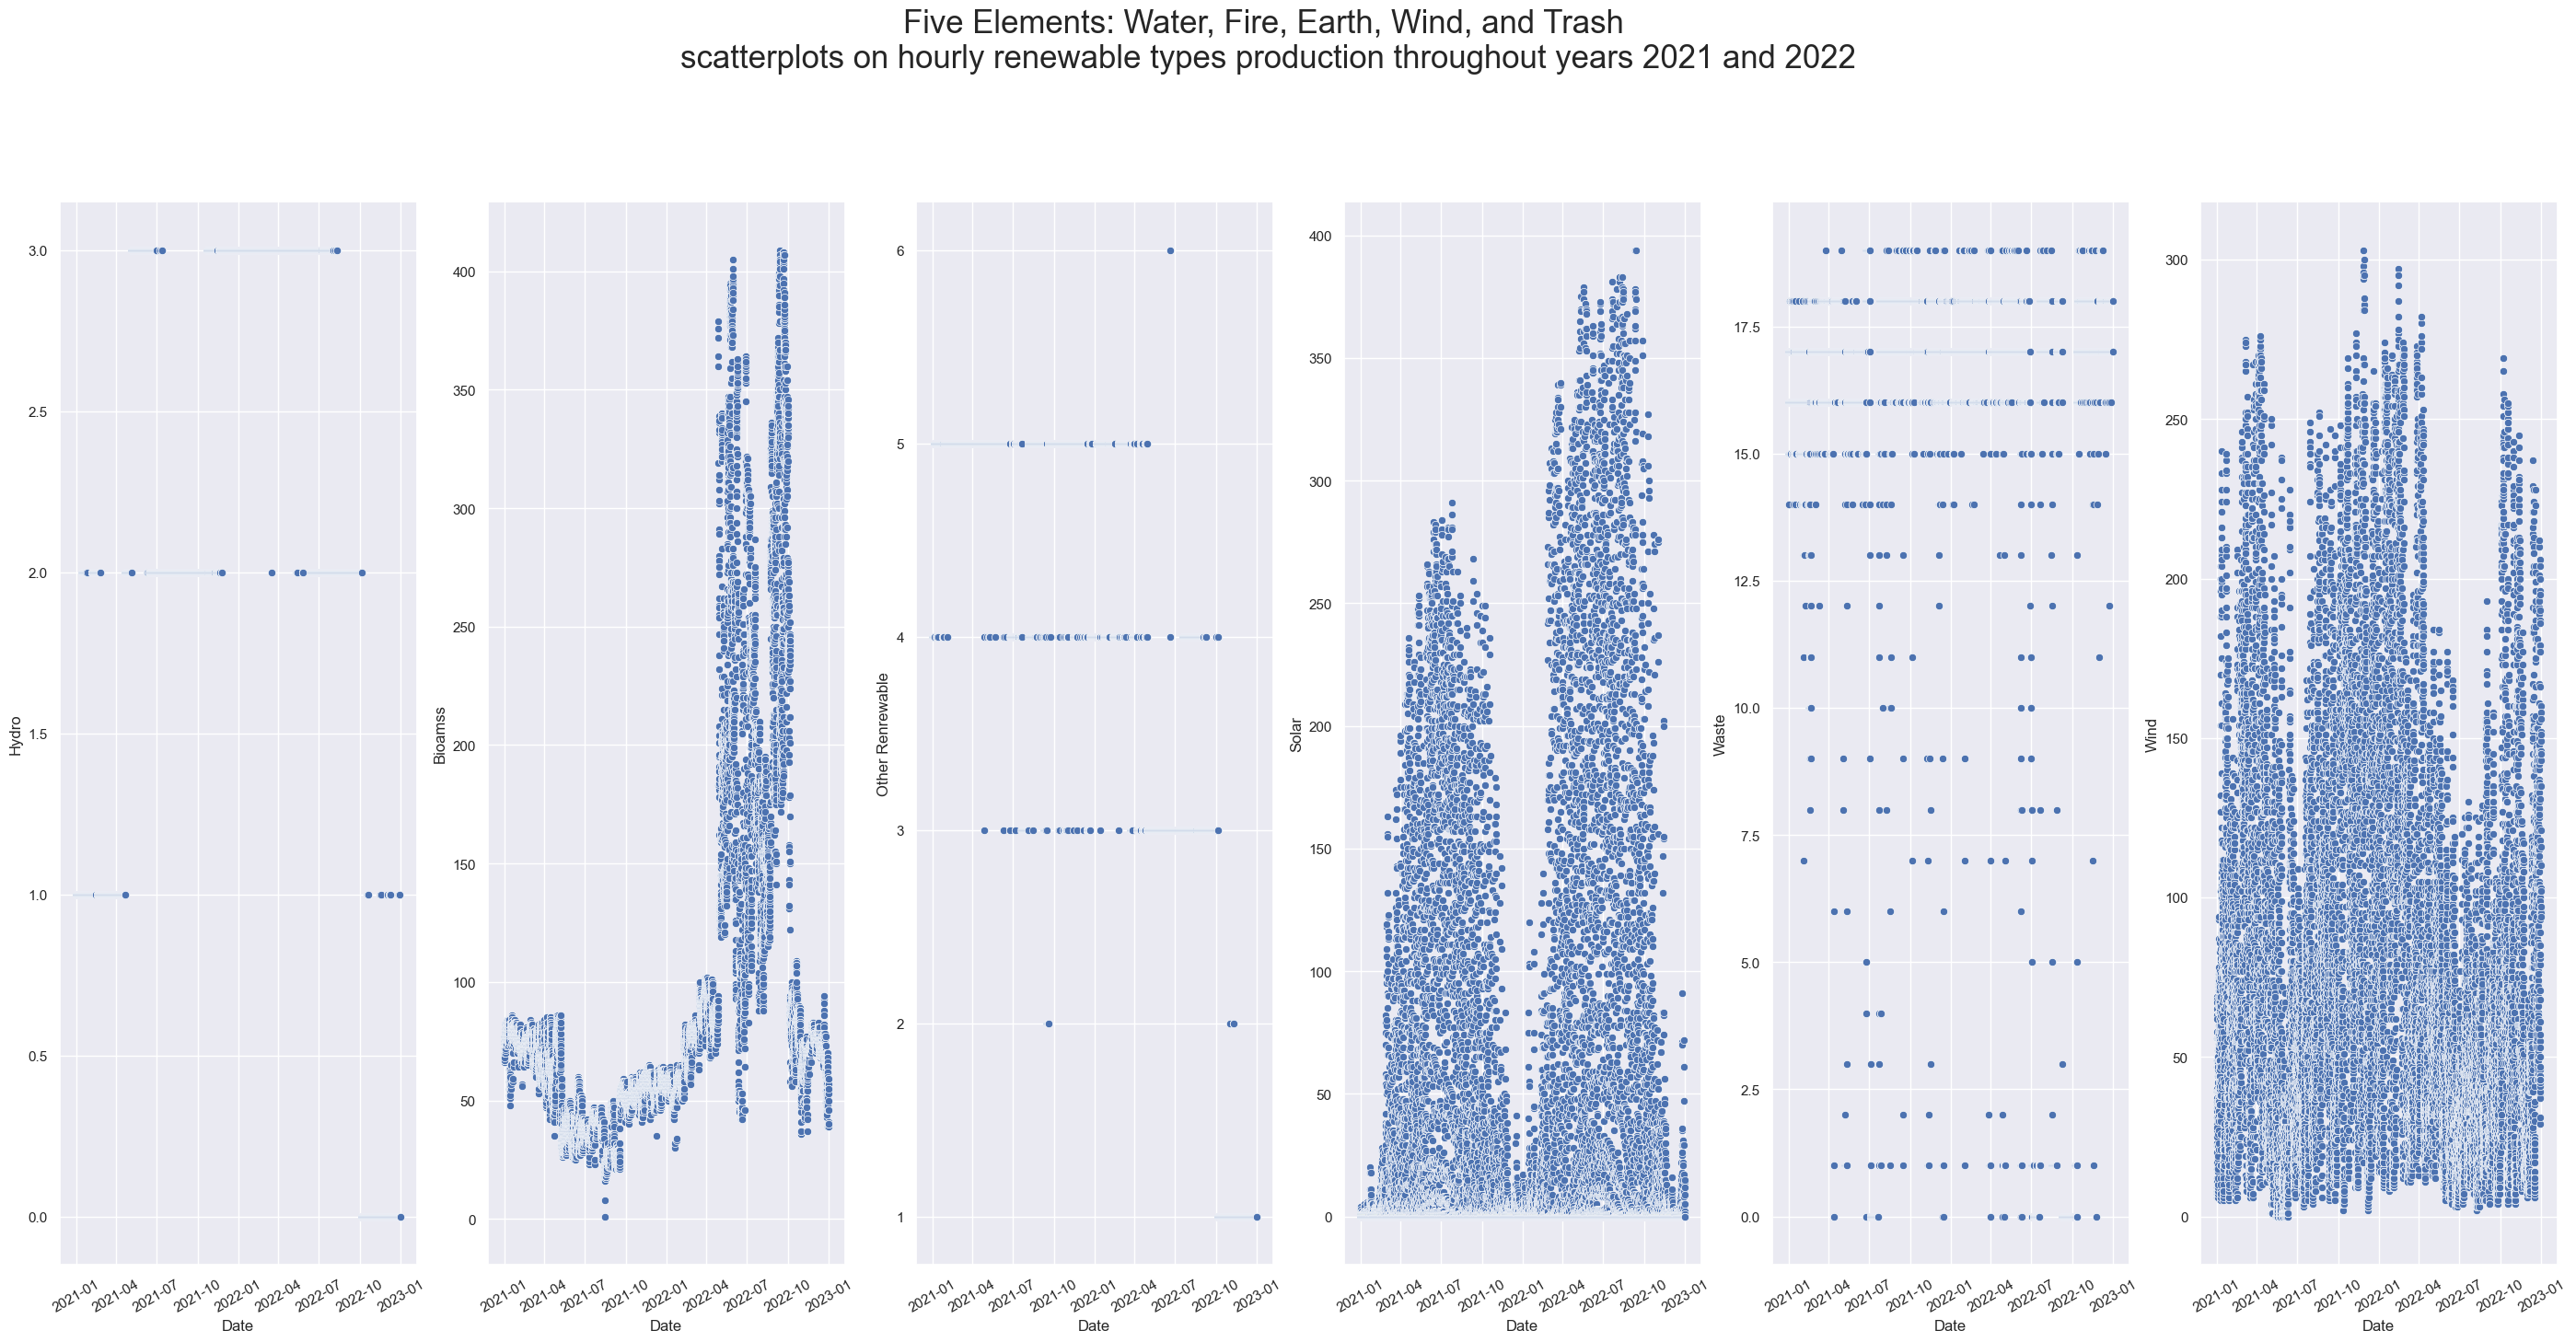

In [25]:
fig, axs = plt.subplots(ncols=6)
fig.set_figheight(15)
fig.set_figwidth(35)

for i, item in enumerate(dic_renewable.items()):
    g = sns.scatterplot(data=df,
                        x=df.date,
                        y=item[1],
                        ax=axs[i]
                        )
    axs[i].set(xlabel = 'Date',
               ylabel= item[0])

    g.set_xticklabels(g.get_xticklabels(), rotation=30)

fig.suptitle(f'Five Elements: Water, Fire, Earth, Wind, and Trash {os.linesep}'
             f'scatterplots on hourly renewable types production throughout years 2021 and 2022', y=1.02, fontsize=25)

Regarding the less fossil-oriented types of electricity production, the distribution of `solar` power is clear -- it is higher during the seasons when sunlight periods are longer, or maybe we just recorded the case of global warming because, in 2022, the production increased because of ozone holes (or maybe more solar panels were installed).
Also, it seems that `biomass` production picked up only in the summer of 2022, while previously, it was not there.
Finally, it seems that `wind` also depends on the season, and my educated guess would be that during spring and autumn, there is more `wind`.

The final plot zooms in on the `hydro run of rivers` because it was not clear from the general plot (due to the poor color selection) what the line is during 2022 at level 3.0.
And it seems that despite winters, the `hydro` power can be obtained at a relatively high level! The line is just a composition of many observations within the period.

<AxesSubplot: xlabel='date', ylabel='hydro_run_of_river_and_poundage'>

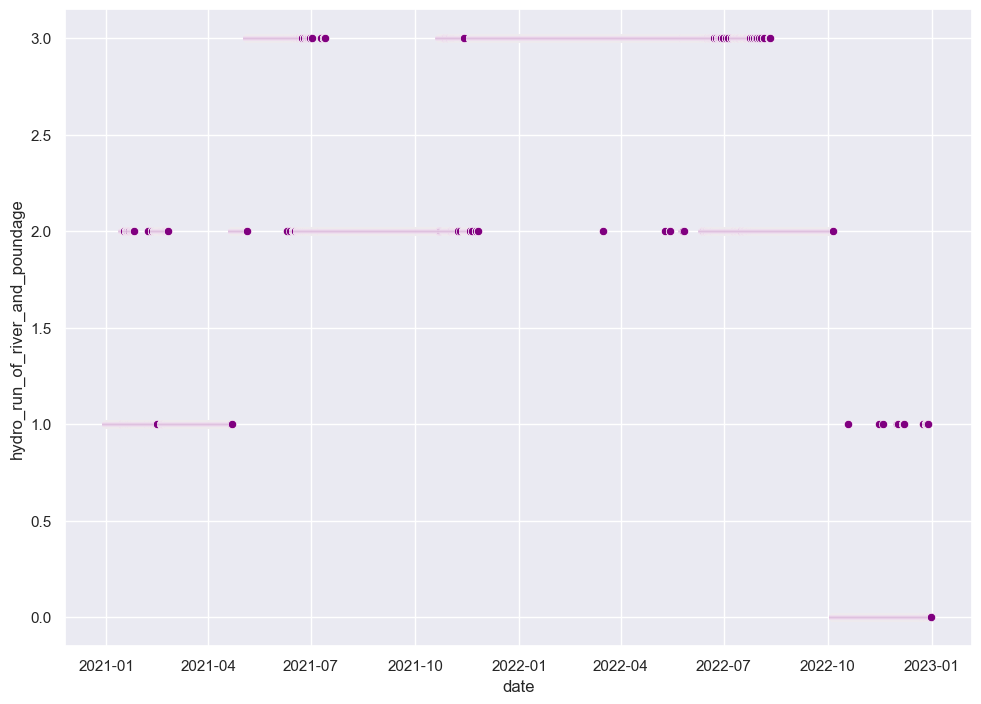

In [26]:
sns.scatterplot(data=df,
             y='hydro_run_of_river_and_poundage',
                x='date',
                color='purple')

#### Subtask 4
**- Find the energy production types that are most stable and most hectic across one year.**

For this task I follow the same fossil-renewable types distinction, but now I increased the scale from hours to months.

Text(0.5, 1.02, 'They are minerals! Oh, I meant fossil...: \nscatterplots on monthly fossil-related production in year 2021')

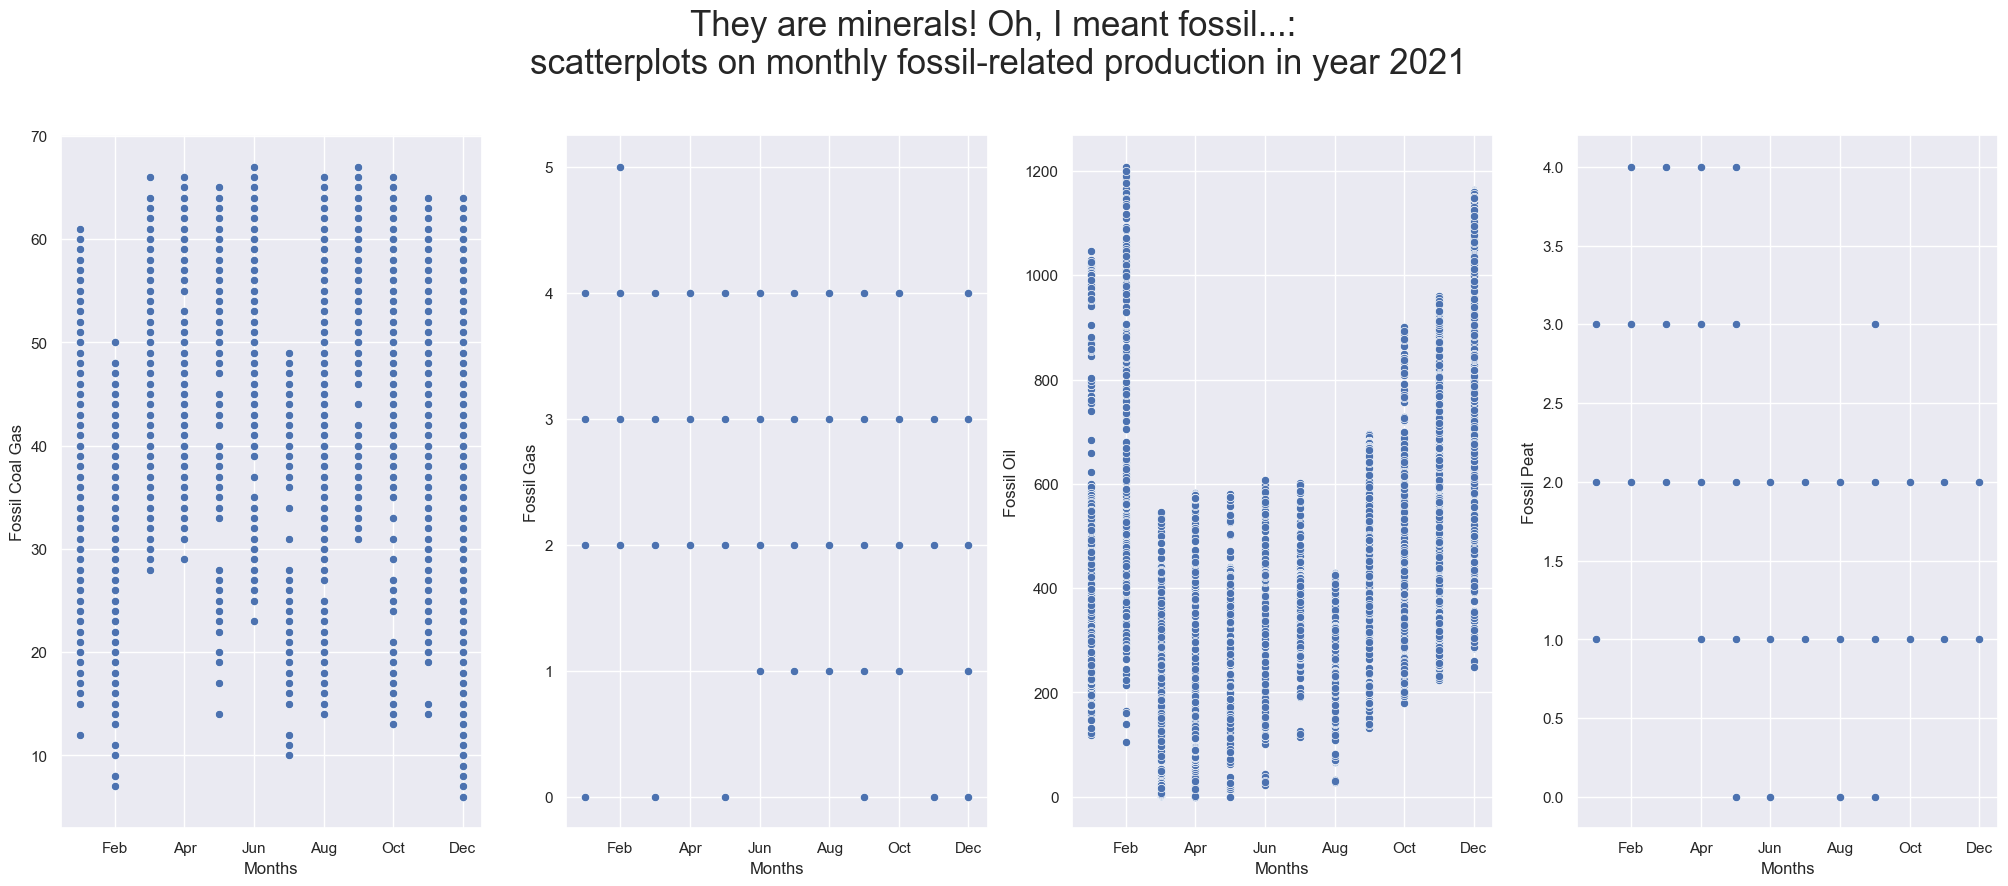

In [27]:
fig, axs = plt.subplots(ncols=4)
fig.set_figheight(9)
fig.set_figwidth(25)

for i, item in enumerate(dic_fossil.items()):
    g = sns.scatterplot(data=df[df.date.dt.year == 2021],
                        x=df.date.dt.month,
                        y=item[1],
                        ax=axs[i])
    axs[i].set(xlabel = 'Months',
               ylabel= item[0])

    g.set_xticklabels(['Jan', 'Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'])

fig.suptitle(f'They are minerals! Oh, I meant fossil...: {os.linesep}'
             'scatterplots on monthly fossil-related production in year 2021', y=1.02, fontsize=25)

Before making assessments, I will define _stability_ and _hecticness_: the former is about not having radical changes in electricity-related production. In contrast, hecticness is exactly about drops and increases.

Speaking about stability, `fossil coal gas`, `fossil gas`, `fossil peat` seems the most stable because they do not have radical fluctuations but just some variance within the values' range. But `fossil oil` is hectic, because the production of electricity based on it falls in March from 1200 to 570.

Text(0.5, 1.02, 'Five Elements: Water, Fire, Earth, Wind, and Trash \nscatterplots on monthly renewable types production in year 2021')

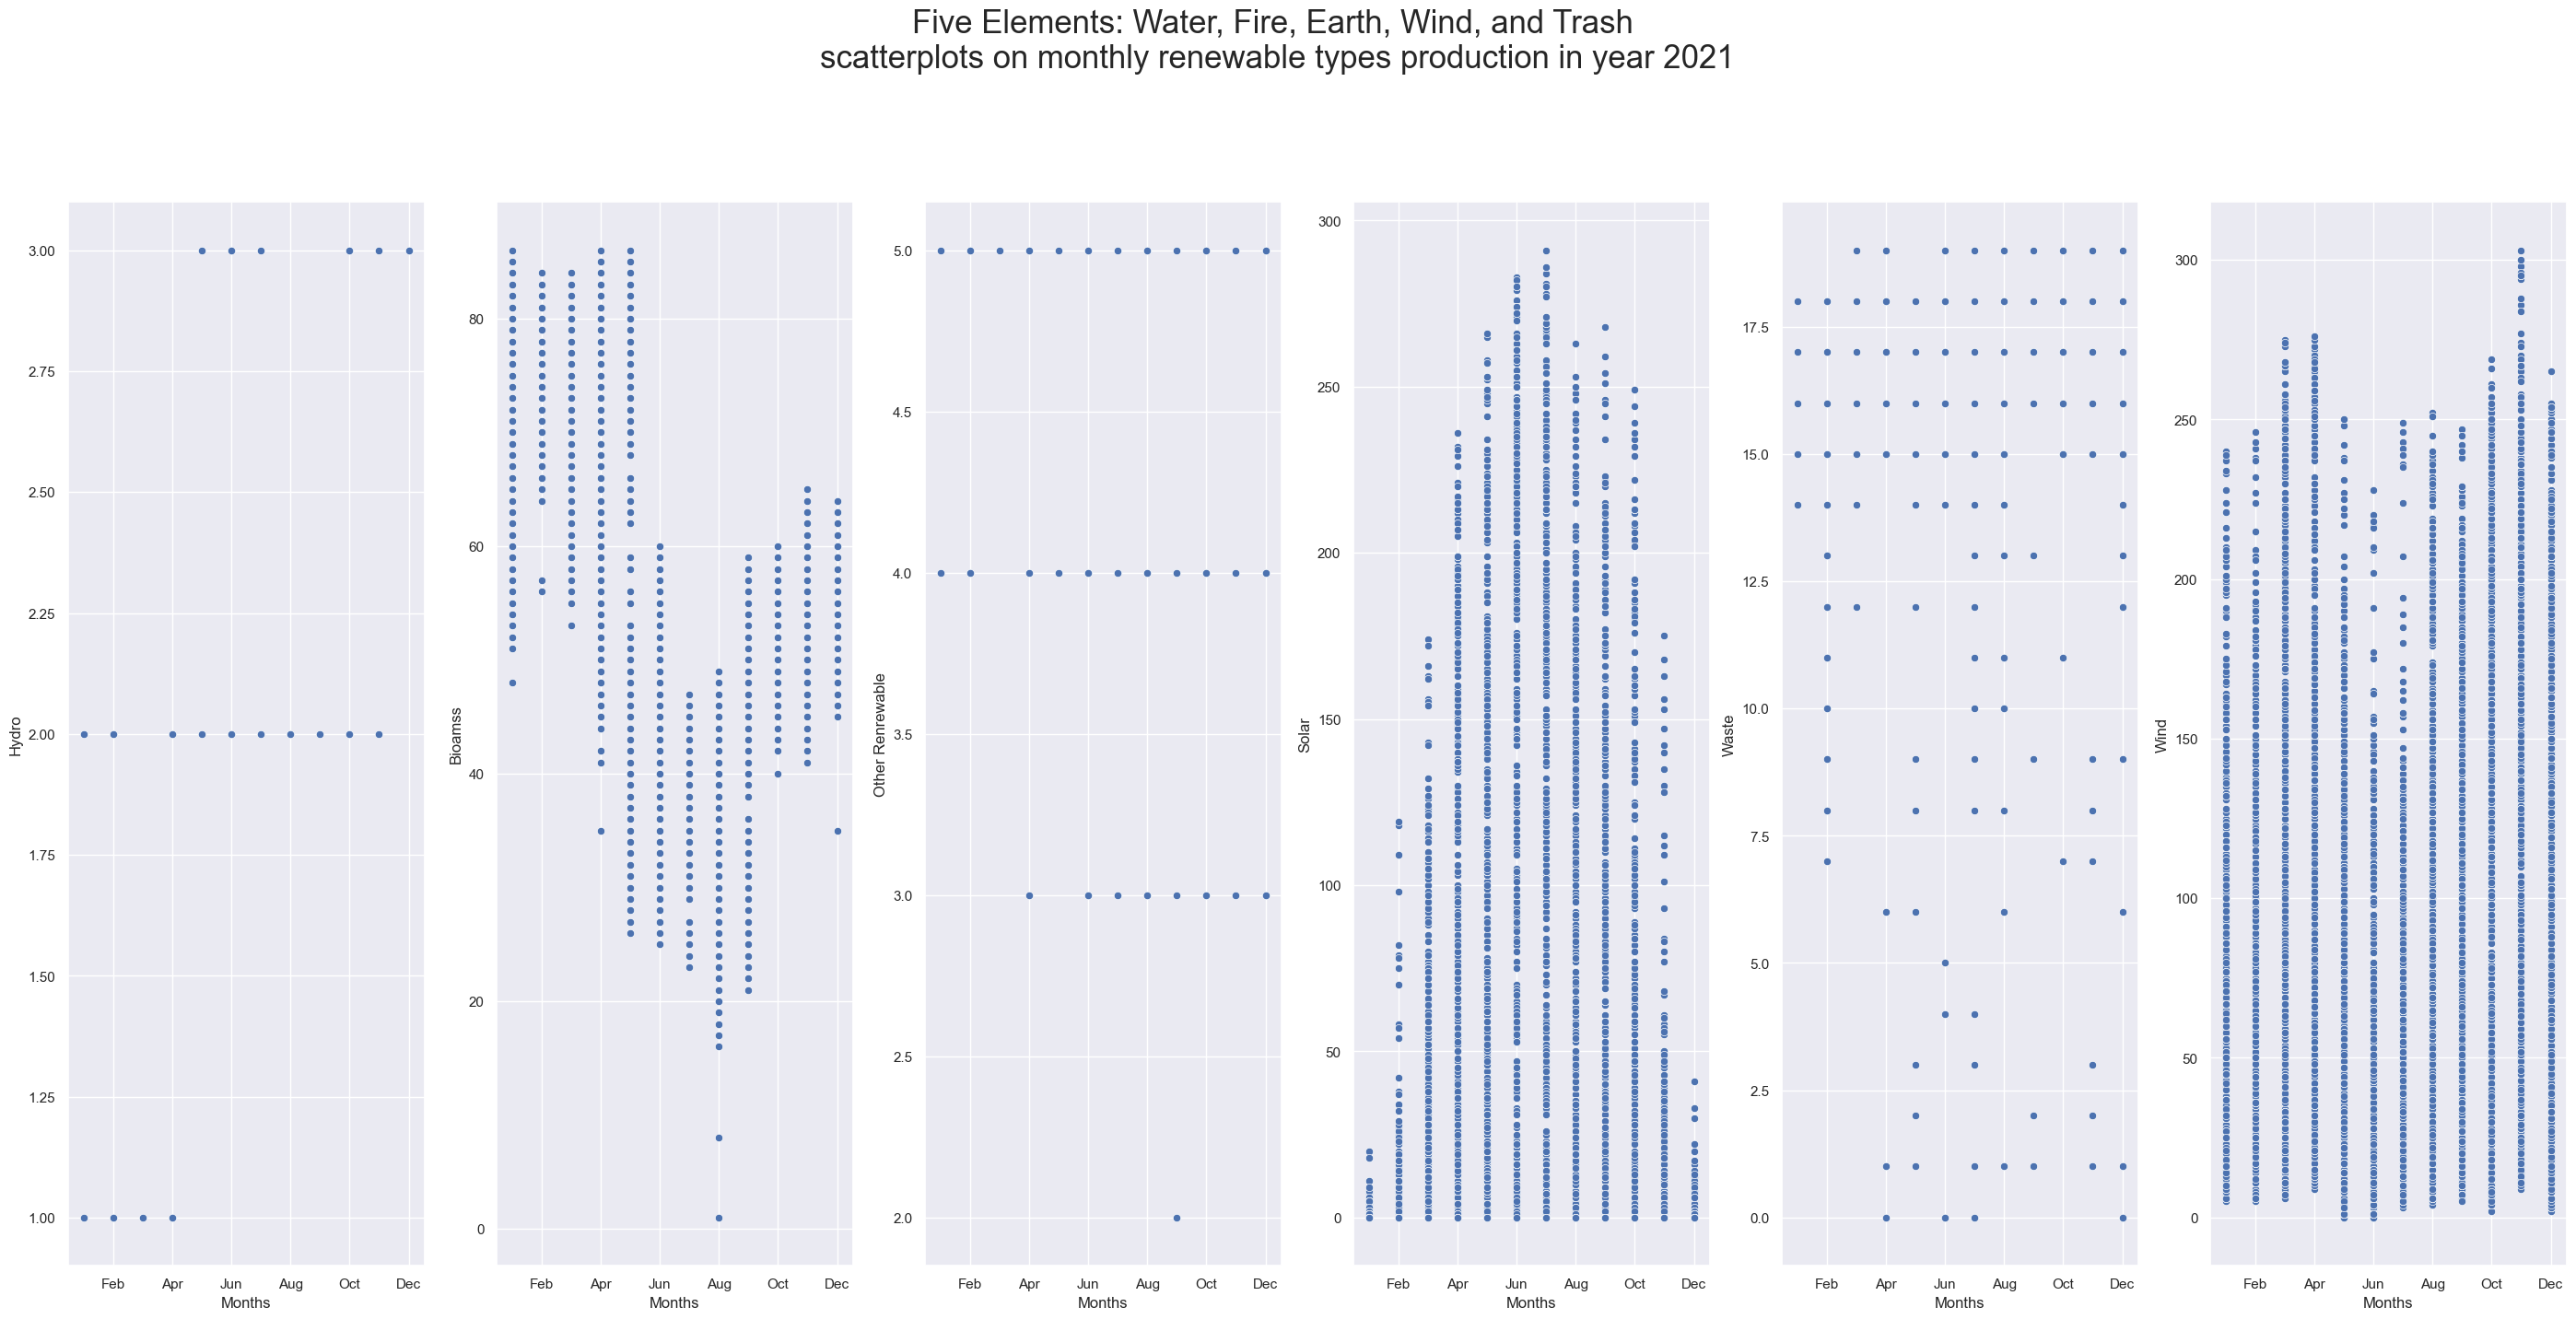

In [28]:
fig, axs = plt.subplots(ncols=6)
fig.set_figheight(15)
fig.set_figwidth(35)

for i, item in enumerate(dic_renewable.items()):
    g = sns.scatterplot(data=df[df.date.dt.year == 2021],
                        x=df.date.dt.month,
                        y=item[1],
                        ax=axs[i])
    axs[i].set(xlabel = 'Months',
               ylabel= item[0])

    g.set_xticklabels(['Jan', 'Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'])


fig.suptitle(f'Five Elements: Water, Fire, Earth, Wind, and Trash {os.linesep}'
             f'scatterplots on monthly renewable types production in year 2021', y=1.02, fontsize=25)

Speaking of renewable sources and electricity production, `hydro`, `waste`, and `wind` (maybe) are stable -- keeping the same level throughout the year. At the same time, `biomass` and `solar` have high values at one point in time, which is later followed by a decrease: in the case of `solar`, it dropped from 270 in July to 35 in December.

#### Subtask 5
**- Find if there exist any clear correlations or patterns between production type/volume and Nord Pool price**

I used a heatmap to assess the connection of variables, so it would be more vivid! And I also tried to keep the same color palette in the notebook, I used the blue theme.

<AxesSubplot: >

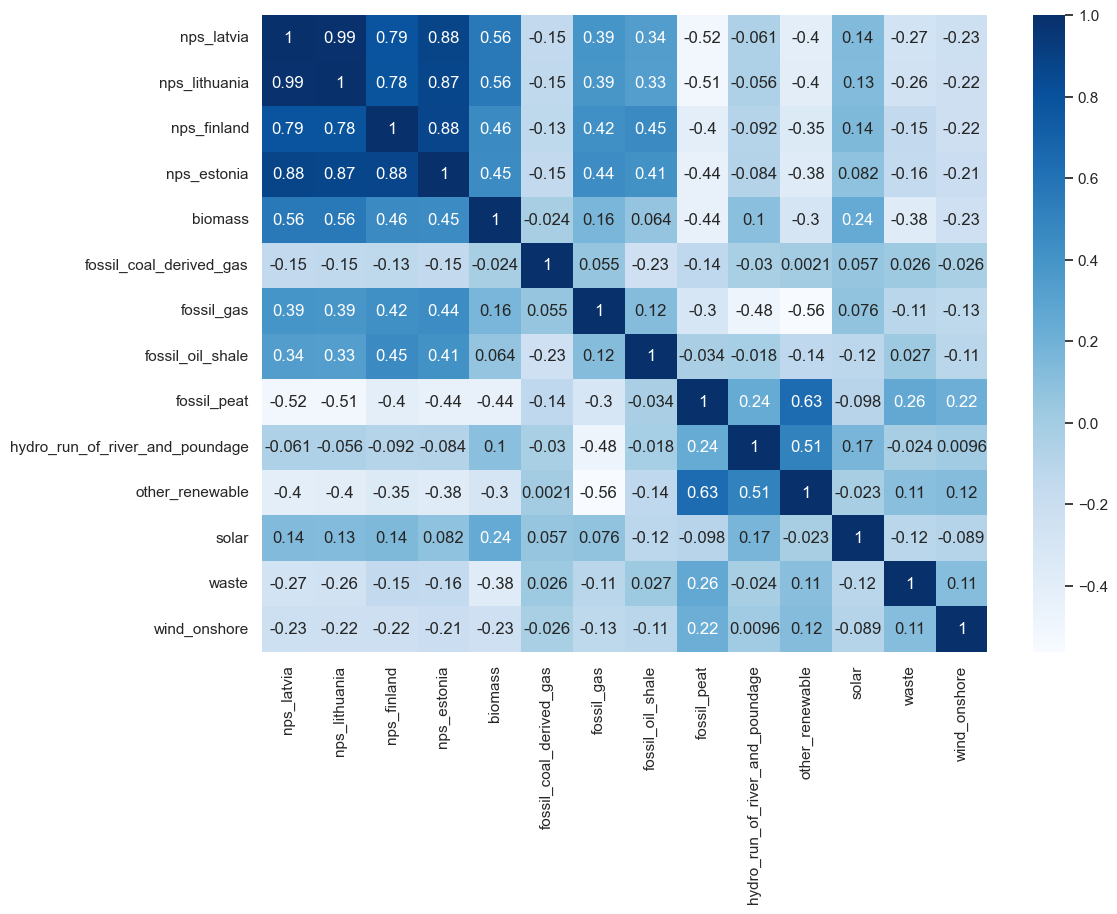

In [29]:
sns.heatmap(df.corr(), annot=True, cmap="Blues")

Surprisingly, there are no strong associations between production type and prices, apart from the slight correlation at level of _0.3-0.4_ between prices and `fossil oil` and `fossil gas`, respectively. Also, `biomass` correlates with prices at the level of _0.4-0.5_.
Despite that, these connections are not significant, but as could be expected, the prices across Baltic countries are strongly connected. For instance, Estonian prices are strongly correlated with Latvia, Lithuanian, and Finnish prices at the level of _0.8_! I will go back to this remark in task 2.

#### Subtask 6
**- Find arguments for or against whether renewable energy production increases Nord Pool price.**

This is the most thought-provoking task, because I had to dive into the topic and go to the Nord Pool to discover the price calculation logic, captured in this picture:

<div>
<img src="https://www.nordpoolgroup.com/48fd87/globalassets/images/trading/surplus_area_deficit_area-1.png?width=640&quality=90" width="1500"/>
</div>

The `solar` and `hydro` powers are always there due to their nature (pardon the pun), while other types depend on the demand and supply. Moreover, the prices in Estonia, as we saw, highly depend on the price in other Baltic states.
So, the solution to the task will be simplistic, I will assume that there is a linear connection between prices and electricity production from renewable sources. This approach violates basic BLUE requirements of linear models mostly because we have time-series data. Ideally, I would like to assess if the war affected the prices somehow, but this is out of the scope.

So, within this task I will run several models to assess the effect of renewable sources on the prices in Estonia.

##### Model 1
All variables are included in the model to assess the overall effect of all production types on prices. I will not include other Baltic countries' data, to at least avoid the endogeneity of variables. Due to the date format, I cannot have it in the model.

In [30]:
iv = df.drop(['nps_estonia', 'date', 'nps_latvia', 'nps_lithuania', 'nps_finland'], axis=1)
dv = df.nps_estonia

In [31]:
x = sm.add_constant(iv)
model = sm.OLS(dv, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            nps_estonia   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     1937.
Date:                Thu, 11 May 2023   Prob (F-statistic):               0.00
Time:                        09:51:02   Log-Likelihood:            -1.0139e+05
No. Observations:               17479   AIC:                         2.028e+05
Df Residuals:                   17468   BIC:                         2.029e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Interpretation for Model 1 is that all renewable sources but `solar` (is not statistically significant) and `wind` (has a small negative coefficient) have a positive impact on the price of electricity in Estonia. It should also be noted that the `hydro`, `fossil gas`, `fossil peat` coefficients are so large just because the values in the dataset are not normalized: e.g., `hydro` values range from 0 to 3, while prices are counted in dozens.
Judging by this model, renewable resources increase the electricity price.
Additional comments are that due to the size of the data frame, almost all variables are statistically significant, and the R-squared, the explanatory metric, is pretty high -- Model 1 explains 50% of the variance in the data.

##### Model 2
Model with only renewable variables for both years.

In [32]:
iv = df.drop(['nps_estonia', 'date', 'nps_latvia', 'nps_lithuania', 'nps_finland', 'fossil_oil_shale', 'fossil_peat', 'fossil_gas', 'fossil_coal_derived_gas'], axis=1)
dv = df.nps_estonia

In [33]:
x = sm.add_constant(iv)
model = sm.OLS(dv, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            nps_estonia   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     1102.
Date:                Thu, 11 May 2023   Prob (F-statistic):               0.00
Time:                        09:51:03   Log-Likelihood:            -1.0511e+05
No. Observations:               17479   AIC:                         2.102e+05
Df Residuals:                   17472   BIC:                         2.103e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

This model represents precisely why I think that this is an excellent task to work on since interpretation is highly tied to the Estonian context. There is not much need to discuss the coefficient for the `hydro` energy because its ratio in the overall production mass is [minimal](https://www.stat.ee/en/uudised/taastuvenergiast-elektri-tootmine-kasvab-joudsalt), so the chances of it changing by one value to increase the price by 3 euros are almost impossible because we saw that in two years it was peaking at 3.0 level (there is not enough variance).
The same logic applies to the `other renewable` sources because they also fluctuated between 4 and 6 within the last two years.

However, we have `biomass`, `solar`, `waste`, and `wind`, which embeds enough variance, and their coefficients we can substantially interpret. `Biomass` has the biggest coefficient, where higher biomass-based electricity production increases the price of electricity. The same direction of causality is observed with `waste`  -- higher production (by one unit) leads to a higher price (by 15 cents).
At the same time, if solar and wind-based productions increase, the price decreases by 2 cents and 18 cents, respectively.

This pattern can be attributed to the supply side of things, depicted at the attached link above; wind constituted 15% of general electricity production, while solar energy -- only 2.1%, which is why coefficients are different.

Summarizing, the conclusions are mixed to the extent that different sources have different impacts on electricity price shifts. An increase in biomass and waste production results in increased prices, while solar and wind types decrease the price. Could it be connected to the cost of production? This question will be answered some time later.

The last comment on the topic is that once I finished the analysis, I approached Andres Võrk, who is teaching a Microeconoetrics course, to chat about the Estonian energy market. He advised adding the demand side of the market, and that brings us back to the graph. I inserted previously -- the current version of the analysis because it does not cover the whole image, only the demand side, which is not the sole explanatory variable.

#### Subtask 7
**- Find whether there are stronger hourly or weekly trends in terms of both energy production and price.**

The approach here was dictated by the moto that simplicity is a key. I did not refer to any comparative test (t-test to check the mean values across two samples; chi-square to assess the likeliness of the distribution, etc.), instead I placed two linechart on the same plot to assess the patterns of distribution visually.

In [34]:
def lineplot_weeks(dic, df):
    fig, axs = plt.subplots(ncols = len(dic))

    if len(dic) <= 4:
        fig.set_figheight(10)
        fig.set_figwidth(25)
    else:
        fig.set_figheight(10)
        fig.set_figwidth(25)

    for i, item in enumerate(dic.items()):
        g = sns.lineplot(data=df,
                         x=df.date.dt.week,
                         y='nps_estonia',
                         ax=axs[i],
                         color='purple',
                         label='Price'
                         )
        g = sns.lineplot(data=df,
                         x=df.date.dt.week,
                         y=item[1],
                         ax=axs[i],
                         color='darkblue',
                         label=item[0])
        axs[i].set(xlabel = 'Weeks',
                   ylabel= item[0])
        axs[i].legend()

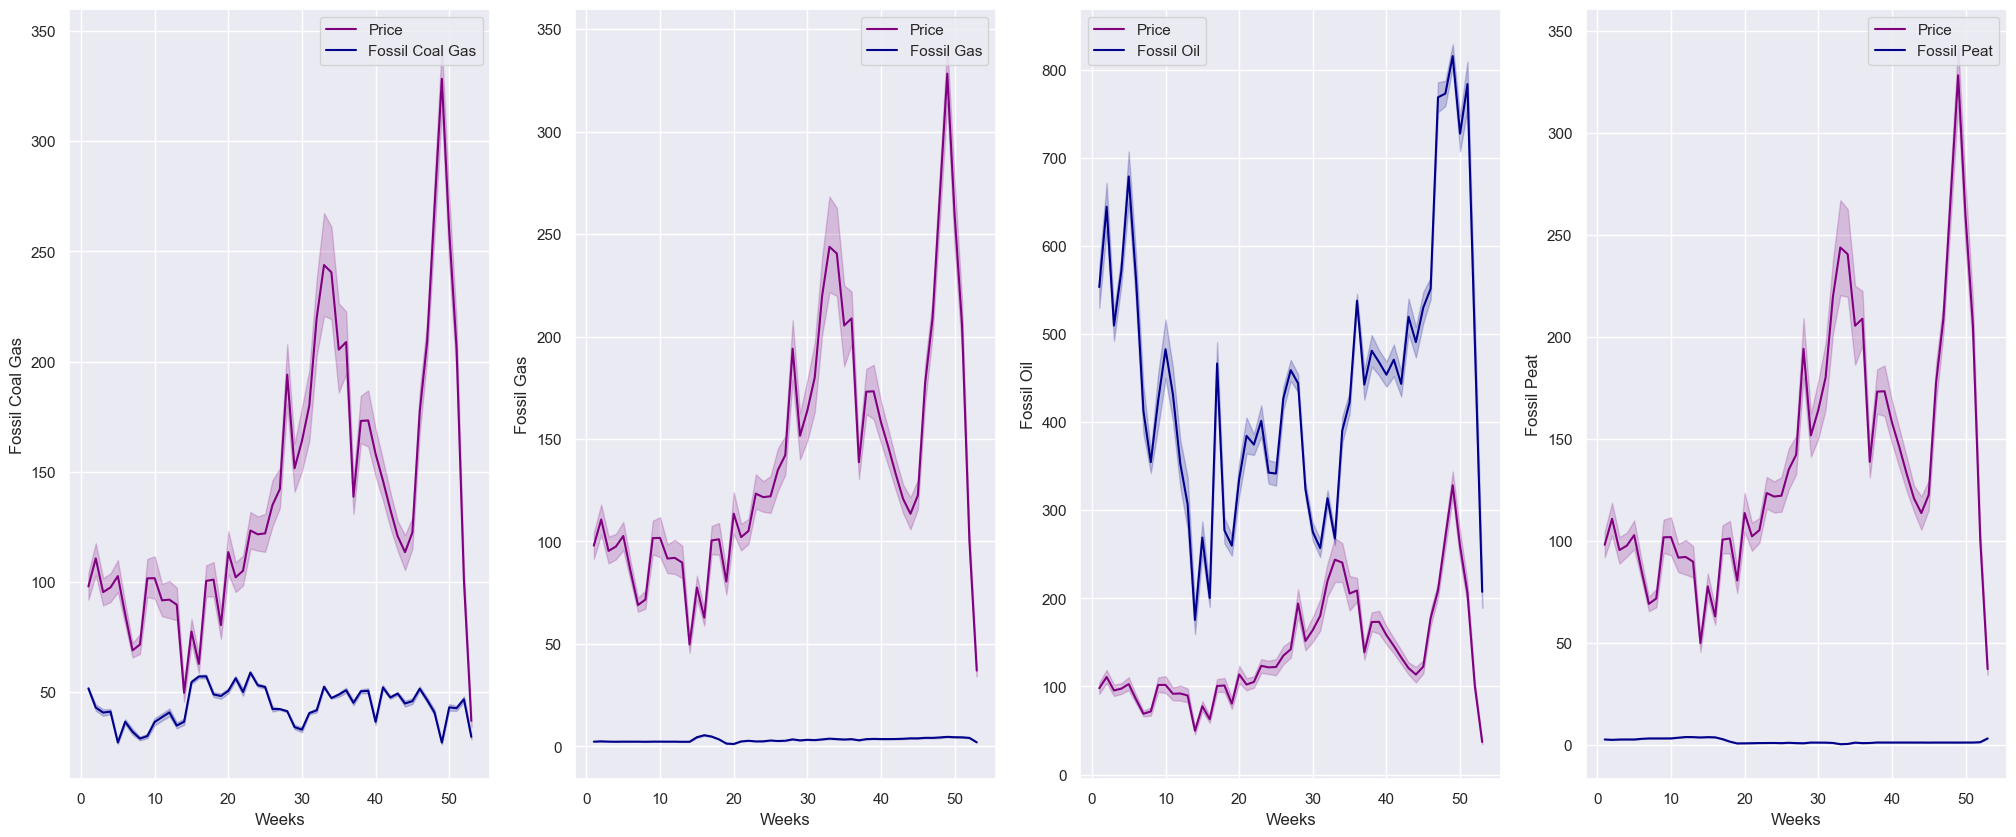

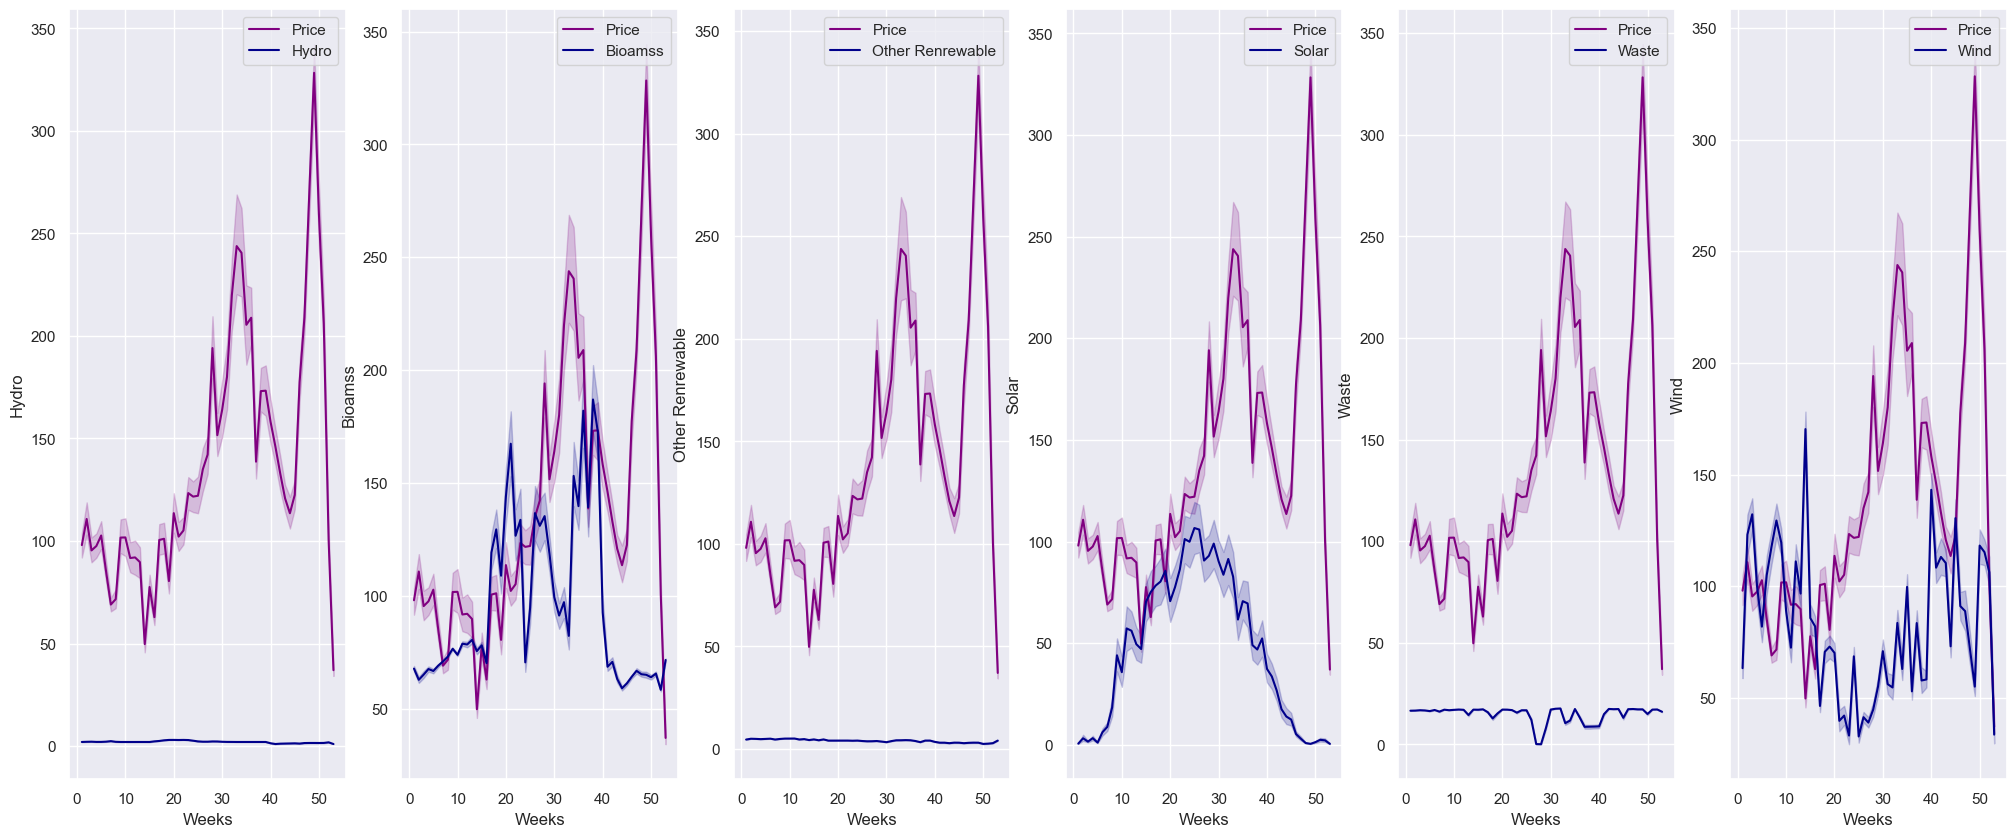

In [35]:
lineplot_weeks(dic_fossil, df)
lineplot_weeks(dic_renewable, df)

In [36]:
def lineplot_hours(dic, df):
    fig, axs = plt.subplots(ncols = len(dic))

    if len(dic) <= 4:
        fig.set_figheight(10)
        fig.set_figwidth(25)
    else:
        fig.set_figheight(10)
        fig.set_figwidth(25)

    for i, item in enumerate(dic.items()):
        g = sns.lineplot(data=df,
                         x=df.date.dt.hour,
                         y='nps_estonia',
                         ax=axs[i],
                         color='purple',
                         label='Price'
                         )
        g = sns.lineplot(data=df,
                         x=df.date.dt.hour,
                         y=item[1],
                         ax=axs[i],
                         color='darkblue',
                         label=item[0])
        axs[i].set(xlabel = 'Hours',
                   ylabel= item[0])
        axs[i].legend()

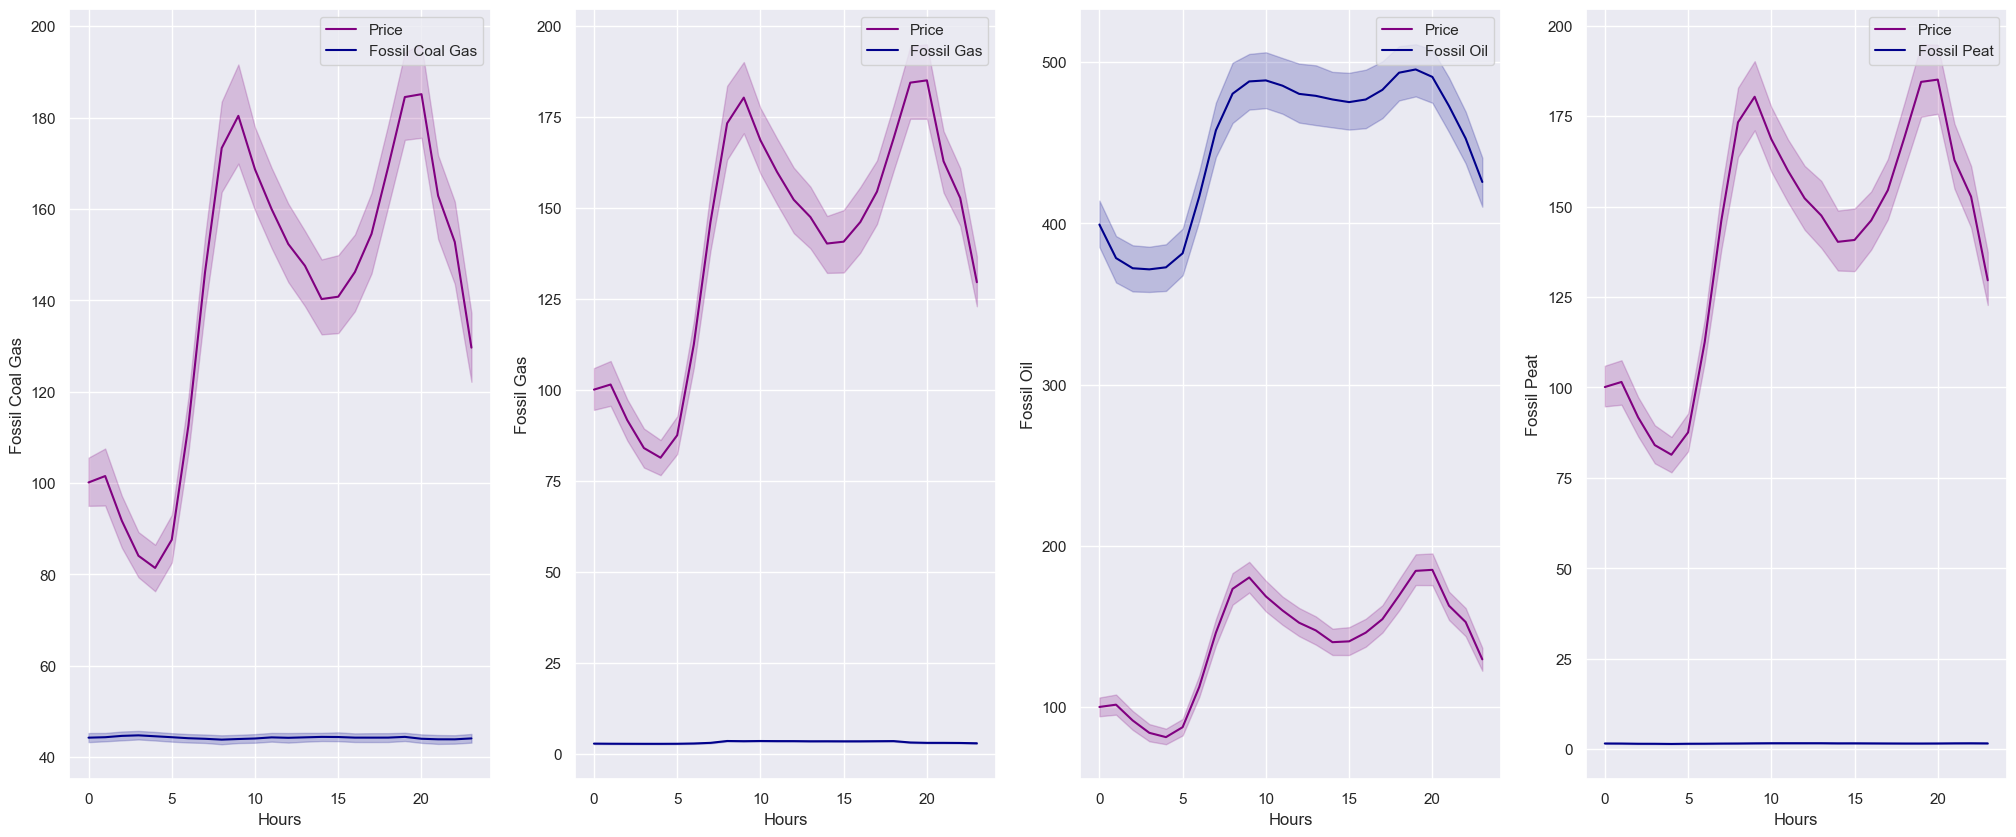

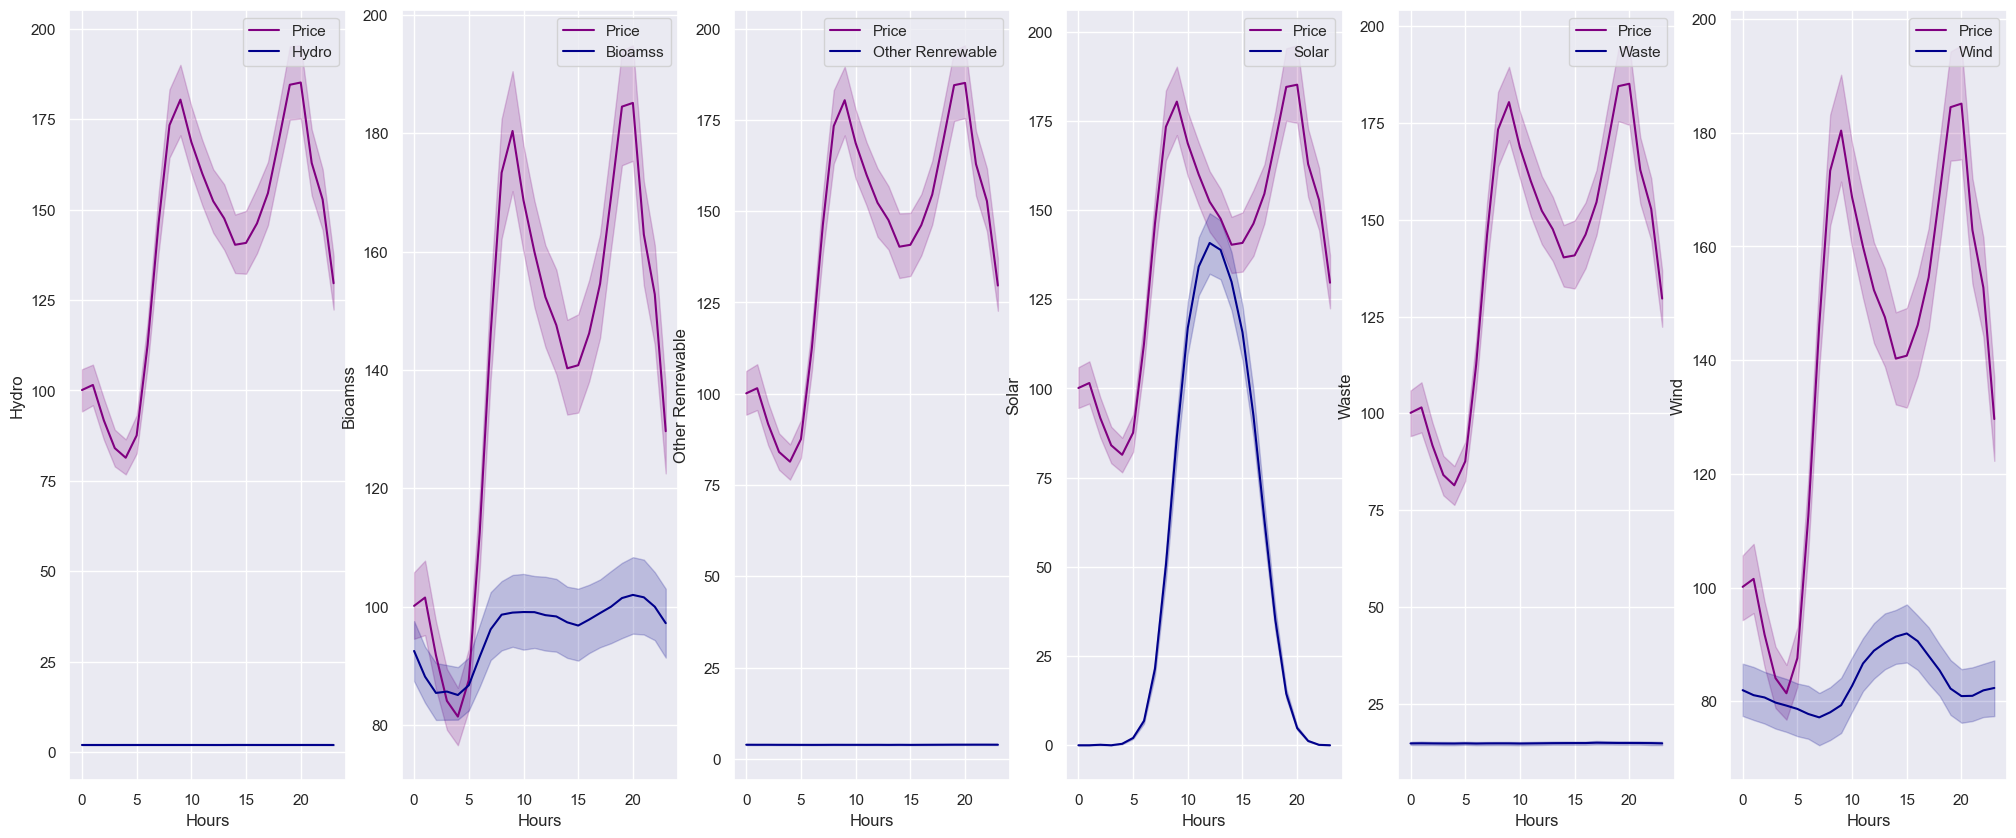

In [37]:
lineplot_hours(dic_fossil, df)
lineplot_hours(dic_renewable, df)

The main conclusion that we can draw from this side-by-side comparison is that hourly data has more trends and can be easily explained. For instance, `fossil oil` has two matching lines, where production duplicates prices. A similar pattern can be witnessed for `biomass`, but the production does not correspond so harshly to the peak hours of 7 AM (before work) and 7 PM (after work).
At the same time, the majority of graphs are flat because of small values.

#### Subtask 8
**- Provide any additional analytics that you see fit.**

I apologize for writing too much text already, so I will not add anything here.

## Task 2. Post-Birthday Electricity Price Prediction

### Task Description

Using the given data, build a model that predicts Estonian Nord Pool energy price for 3 days after your last year's birthday.

- State when is your birthday (if by any extraordinary chance you have your birthday on the 29th of February, choose something close to it).
- Feel free to implement any model you like.
- Include reasonable performance metrics for your model (justify your choice of metrics).
- Make sure to visualize the results/predictions.

### Model 1
The laziest linear model with all variables from the merged dataframe and Linear Regression model trained on daily data.

My birthday is on 24 of March, and citing one of the old memes 'Dates, here we go again'!
Since I can't use `train_test_split` in this case, so in order to split the data into train and test based on the cut-off point of birthday, I had to convert every date to the same format! Here I also do not have enought experience with datetime objects and timestamps, so I convert my datetime64 birthday to timestamp in Estonian timezone like this:

In [38]:
BIRTHDAY = np.datetime64('2022-03-24 00:00:00')
FORMAT = '%Y-%m-%d %H:%M:%S'

In [39]:
dt_arr = np.array([BIRTHDAY],
                  dtype='datetime64[ns]')
df_np = pd.DataFrame(dt_arr)
df_np[0] = df_np[0].dt.tz_localize('Europe/Tallinn')

birthdate = df_np.iloc[0][0]

birthdate = birthdate.strftime('%Y-%m-%d %H:%M:%S')
birthdate = datetime.strptime(birthdate, FORMAT)
birthdate

datetime.datetime(2022, 3, 24, 0, 0)

Then I convert `date` to datetime object as well.

In [40]:
df.date = [i.strftime('%Y-%m-%d %H:%M:%S') for i in df.date]

In [41]:
df.date = [datetime.strptime(i, FORMAT) for i in df.date]

Next stage is to transform hourly data to daily!

In [42]:
df_daily = df.resample('24H', on = 'date').mean()
df_daily.reset_index(inplace=True)
df_daily

date  nps_latvia  nps_lithuania  nps_finland  nps_estonia  \
0   2021-01-01   36.170833      36.170833    26.185417    36.170833   
1   2021-01-02   42.592500      42.592500    32.799583    42.592500   
2   2021-01-03   32.249167      32.249167    25.869167    32.249167   
3   2021-01-04   43.467083      43.783333    43.260000    43.467083   
4   2021-01-05   47.209167      47.209167    47.209167    47.209167   
..         ...         ...            ...          ...          ...   
724 2022-12-26   42.062917      42.062917    35.839583    42.062917   
725 2022-12-27   96.611250      96.611250    88.017083    96.611250   
726 2022-12-28  129.002500     129.002500   115.064167   129.002500   
727 2022-12-29   97.807917      97.807917    55.034167    97.807917   
728 2022-12-30   58.163333      58.163333    18.642500    58.163333   

       biomass  fossil_coal_derived_gas  fossil_gas  fossil_oil_shale  \
0    69.208333                28.333333    2.000000        144.041667   
1    71.791667                29.791667    2.000000        264.041667   
2    73.583333                31.166667    2.000000        214.000000   
3    76.833333                54.083333    2.958333        328.458333   
4    77.541667                55.958333    2.833333        351.625000   
..         ...                      ...         ...               ...   
724  55.875000                46.708333    6.708333        278.666667   
725  61.250000                49.750000    6.791667        344.333333   
726  65.458333                57.166667    6.750000        384.583333   
727  62.500000                56.333333    7.000000        330.166667   
728  50.250000                61.041667    6.875000        259.958333   

     fossil_peat  hydro_run_of_river_and_poundage  other_renewable     solar  \
0            3.0                         1.000000              4.0  0.625000   
1            3.0                         1.000000              4.0  0.500000   
2            3.0                         1.000000              4.0  0.333333   
3            3.0                         1.000000              4.0  0.166667   
4            3.0                         1.000000              4.0  0.208333   
..           ...                              ...              ...       ...   
724          0.0                         0.333333              1.0  4.333333   
725          0.0                         0.375000              1.0  3.083333   
726          0.0                         0.208333              1.0  9.666667   
727          0.0                         0.000000              1.0  1.583333   
728          0.0                         0.000000              1.0  2.416667   

         waste  wind_onshore  
0    15.416667     19.125000  
1    15.625000     46.083333  
2    17.041667     35.416667  
3    16.458333     13.458333  
4    15.666667     40.500000  
..         ...           ...  
724  17.166667    124.541667  
725  17.250000    161.083333  
726  17.416667     68.333333  
727  17.625000    110.583333  
728  17.583333    135.750000  

[729 rows x 15 columns]

In [43]:
X_train_train = df_daily[df_daily['date'] <= birthdate]
X_test_test = df_daily[df_daily['date'] > birthdate].head(3)

In [44]:
X_train = X_train_train.drop(['nps_estonia', 'date'], axis=1)
y_train = X_train_train['nps_estonia']

X_test = X_test_test.drop(['nps_estonia', 'date'], axis=1)
y_test = X_test_test['nps_estonia']

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

If the last year's internship test assignment was about classification, there I could use accuracy, recall, and precision metrics as well as their derivatives. Here the task is to predict the price, so I opt for RMSE and MAE: the former is just the default metric in prediction tasks, while absolute values I can use for interpretation.

In [46]:
print(f'RMSE for the Model 1 is: {mean_squared_error(y_test, y_pred, squared=False).round(3)}')
print(f'MAE for the Model 1 is: {mean_absolute_error(y_test, y_pred).round(3)}')

RMSE for the Model 1 is: 10.872
MAE for the Model 1 is: 9.426


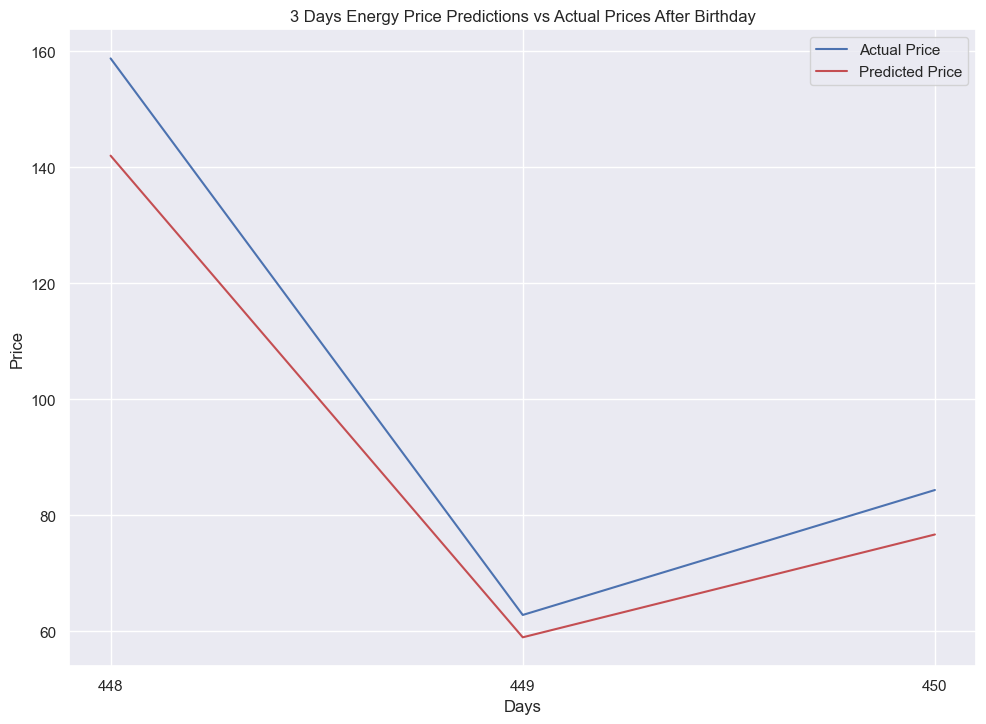

In [47]:
plt.plot(X_test.index, y_test, 'b', label='Actual Price')
plt.plot(X_test.index, y_pred, 'r', label='Predicted Price')
plt.title('3 Days Energy Price Predictions vs Actual Prices After Birthday')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks([448, 449, 450])
plt.legend()
plt.show()

Perfect! I trained an almost ideal model that predicts price with a 9 euros error, which is virtually nothing on our scale!
I already sent the script to Eesti Energia so they could deploy the script in production.

### Model 2
Jokes aside, the previous model is overfitted, has redundant variables (e.g., nps_latvia, nps_finland, etc.), and has daily data aggregated based on the mean value(!!!). Something more sophisticated is required, that is why I propose to conduct feature engineering by adding a variable of 3-day-lagged prices in Estonia, adding a temporal variable, standardizing data via `StandardScaler` (because we saw in the first task how different distributions are), and including historical weather data from [Keskkonnaagentuur](https://www.ilmateenistus.ee/kliima/ajaloolised-ilmaandmed/)(I use Tallinn data).

Not lazy Random Forest model with omitted variables, feature engineering, and hyperparameter tuning on hourly data.

Uploading weather data from Keskkonnaagentuur.

In [48]:
df_weather = pd.read_csv('tallinn_harku.csv', error_bad_lines=False, sep=';')

Here I have to change some variables' format because they were initially stored with commas.

In [49]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17878 entries, 0 to 17877
Data columns (total 15 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   year                                              17878 non-null  int64  
 1   month                                             17878 non-null  int64  
 2   day                                               17878 non-null  int64  
 3   hour_utc                                          17878 non-null  object 
 4   Hourly_average_total_radiation_W/m_               17878 non-null  int64  
 5   Air_pressure_at_sea_level_hPa                     17878 non-null  object 
 6   Air_pressure_at_the_height_of_the_station_in_hPa  17878 non-null  object 
 7   Amount_of_hourly_precipitation_in_mm              17878 non-null  object 
 8   Relative_humidity_%                               17878 non-null  int64  
 9   Air_temperature_°

In [50]:
for col in df_weather.iloc[:, 4:].select_dtypes(object):
    df_weather[col] = pd.to_numeric(df_weather[col].str.replace(',','.'), errors='coerce')

df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17878 entries, 0 to 17877
Data columns (total 15 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   year                                              17878 non-null  int64  
 1   month                                             17878 non-null  int64  
 2   day                                               17878 non-null  int64  
 3   hour_utc                                          17878 non-null  object 
 4   Hourly_average_total_radiation_W/m_               17878 non-null  int64  
 5   Air_pressure_at_sea_level_hPa                     17878 non-null  float64
 6   Air_pressure_at_the_height_of_the_station_in_hPa  17878 non-null  float64
 7   Amount_of_hourly_precipitation_in_mm              17878 non-null  float64
 8   Relative_humidity_%                               17878 non-null  int64  
 9   Air_temperature_°

In [51]:
df_weather.columns = col_names_formatting(df_weather)
df_weather.columns

Index(['year', 'month', 'day', 'hour_utc',
       'hourly_average_total_radiation_w_m_', 'air_pressure_at_sea_level_hpa',
       'air_pressure_at_the_height_of_the_station_in_hpa',
       'amount_of_hourly_precipitation_in_mm', 'relative_humidity_%',
       'air_temperature_c', 'hourly_minimum_air_temperature_c',
       'hourly_maximum_air_temperature_c', '10_minute_average_wind_direction_',
       '10_minute_average_wind_speed_m_s', 'hourly_maximum_wind_speed_m_s'],
      dtype='object')

I created datetime object for the weather dataframe to merge it with our original production-price dataset.

In [52]:
df_weather['date'] = pd.to_datetime(df_weather['year'].apply(str) + '-' + df_weather['month'].apply(str) + '-' + df_weather['day'].apply(str) + ' ' + df_weather['hour_utc'].apply(str))

In [53]:
df_weather = df_weather.drop(['year', 'month', 'day', 'hour_utc'], axis=1)

In [54]:
df_weather.date = df_weather.date.dt.tz_localize('UTC', ambiguous='NaT')

In [55]:
df_weather.date = df_weather.date.dt.tz_convert('Europe/Tallinn')

In [56]:
df_weather.date = [i.strftime('%Y-%m-%d %H:%M:%S') for i in df_weather.date]
df_weather.date = [datetime.strptime(i, FORMAT) for i in df_weather.date]

In [57]:
prod_price_weather = pd.merge(df, df_weather, on='date')
prod_price_weather.head()

date  nps_latvia  nps_lithuania  nps_finland  nps_estonia  \
0 2021-01-01 00:00:00       24.07          24.07        24.07        24.07   
1 2021-01-01 01:00:00       24.95          24.95        24.95        24.95   
2 2021-01-01 02:00:00       24.35          24.35        24.35        24.35   
3 2021-01-01 03:00:00       23.98          23.98        23.98        23.98   
4 2021-01-01 04:00:00       23.72          23.72        23.72        23.72   

   biomass  fossil_coal_derived_gas  fossil_gas  fossil_oil_shale  \
0     71.0                     26.0         2.0             150.0   
1     70.0                     26.0         2.0             156.0   
2     69.0                     27.0         2.0             119.0   
3     69.0                     26.0         2.0             123.0   
4     66.0                     24.0         2.0             121.0   

   fossil_peat  ...  air_pressure_at_sea_level_hpa  \
0          3.0  ...                         1010.2   
1          3.0  ...                         1010.3   
2          3.0  ...                         1010.4   
3          3.0  ...                         1010.9   
4          3.0  ...                         1011.1   

   air_pressure_at_the_height_of_the_station_in_hpa  \
0                                            1006.0   
1                                            1006.1   
2                                            1006.3   
3                                            1006.7   
4                                            1007.0   

   amount_of_hourly_precipitation_in_mm  relative_humidity_%  \
0                                   0.0                  100   
1                                   0.0                  100   
2                                   0.0                  100   
3                                   0.0                  100   
4                                   0.0                   99   

   air_temperature_c  hourly_minimum_air_temperature_c  \
0                0.1                               0.1   
1                0.4                               0.0   
2                1.0                               0.4   
3                1.2                               0.9   
4                1.4                               1.2   

   hourly_maximum_air_temperature_c  10_minute_average_wind_direction_  \
0                               0.2                              185.0   
1                               0.4                              187.0   
2                               1.0                              197.0   
3                               1.2                              189.0   
4                               1.5                              192.0   

   10_minute_average_wind_speed_m_s  hourly_maximum_wind_speed_m_s  
0                               1.8                            4.9  
1                               2.2                            4.5  
2                               3.2                            5.5  
3                               1.8                            5.1  
4                               1.9                            3.7  

[5 rows x 26 columns]

Also, since I cannot include datetime objects in the models, I will convert those to numeric.

In [58]:
prod_price_weather['date_num'] = pd.to_datetime(prod_price_weather['date'])
prod_price_weather['date_num'] = prod_price_weather['date'].map(datetime.toordinal)

Let us continue by lagging Estonian prices by three days.

In [59]:
prod_price_weather['lag_price'] = prod_price_weather['nps_estonia'].shift(72)
prod_price_weather = prod_price_weather.fillna(0)
prod_price_weather.head()

date  nps_latvia  nps_lithuania  nps_finland  nps_estonia  \
0 2021-01-01 00:00:00       24.07          24.07        24.07        24.07   
1 2021-01-01 01:00:00       24.95          24.95        24.95        24.95   
2 2021-01-01 02:00:00       24.35          24.35        24.35        24.35   
3 2021-01-01 03:00:00       23.98          23.98        23.98        23.98   
4 2021-01-01 04:00:00       23.72          23.72        23.72        23.72   

   biomass  fossil_coal_derived_gas  fossil_gas  fossil_oil_shale  \
0     71.0                     26.0         2.0             150.0   
1     70.0                     26.0         2.0             156.0   
2     69.0                     27.0         2.0             119.0   
3     69.0                     26.0         2.0             123.0   
4     66.0                     24.0         2.0             121.0   

   fossil_peat  ...  amount_of_hourly_precipitation_in_mm  \
0          3.0  ...                                   0.0   
1          3.0  ...                                   0.0   
2          3.0  ...                                   0.0   
3          3.0  ...                                   0.0   
4          3.0  ...                                   0.0   

   relative_humidity_%  air_temperature_c  hourly_minimum_air_temperature_c  \
0                  100                0.1                               0.1   
1                  100                0.4                               0.0   
2                  100                1.0                               0.4   
3                  100                1.2                               0.9   
4                   99                1.4                               1.2   

   hourly_maximum_air_temperature_c  10_minute_average_wind_direction_  \
0                               0.2                              185.0   
1                               0.4                              187.0   
2                               1.0                              197.0   
3                               1.2                              189.0   
4                               1.5                              192.0   

   10_minute_average_wind_speed_m_s  hourly_maximum_wind_speed_m_s  date_num  \
0                               1.8                            4.9    737791   
1                               2.2                            4.5    737791   
2                               3.2                            5.5    737791   
3                               1.8                            5.1    737791   
4                               1.9                            3.7    737791   

   lag_price  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  

[5 rows x 28 columns]

In [60]:
prod_price_weather.to_csv('weather_production_prices.csv')

Here it is, what seems to be the last data frame with all necessary variables and in the correct timezone (I hope)!

In [61]:
X_train_train = prod_price_weather[prod_price_weather['date'] <= birthdate]
X_test_test = prod_price_weather[prod_price_weather['date'] > birthdate].head(72)

Since we still cannot use even `TimeSeriesSplit`, I split data to train-test manually, and now test data has 72 observations, which is three days equivalent in hours.

In [62]:
X_train = X_train_train.drop(['nps_estonia', 'nps_lithuania', 'nps_finland', 'nps_latvia', 'date'], axis=1)
y_train = X_train_train['nps_estonia']

In [63]:
X_test = X_test_test.drop(['nps_estonia', 'nps_lithuania', 'nps_finland', 'nps_latvia', 'date'], axis=1)
y_test = X_test_test['nps_estonia']

In [64]:
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

In [65]:
t = [('StandardScaler', StandardScaler(), numeric_cols_idx)]

col_transform = ColumnTransformer(transformers=t)

In [66]:
param_grid = {
    "random_forest__max_depth": [10, 15, 20],
    "random_forest__min_samples_split": [2, 5, 10],
    "random_forest__min_samples_leaf": [1, 3, 5]
}

### Your code is here
pipe_rf = Pipeline([('transformer', col_transform),
                    ('random_forest', RandomForestRegressor())])

search = GridSearchCV(pipe_rf,
                      param_grid,
                      cv=4,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 1/4; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-4446.025 total time=   7.3s
[CV 2/4; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 2/4; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-475.103 total time=   6.6s
[CV 3/4; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2
[CV 3/4; 1/27] END random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_split=2;, score=-2591.538 total time=   6.7s
[CV 4/4; 1/27] START random_forest__max_depth=10, random_forest__min_samples_leaf=1, random_forest__min_samples_sp

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('StandardScaler',
                                                                         StandardScaler(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22])])),
                                       ('random_forest',
                                        RandomForestRegressor())]),
             param_grid={'random_forest__max_depth': [10, 15, 20],
                         'random_forest__min_samples_leaf': [1, 3, 5],
                         'random_forest__min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=10)

In [67]:
y_pred = search.predict(X_test)

print(f'RMSE for the Model 2 is: {mean_squared_error(y_test, y_pred, squared=False).round(3)}')
print(f'MAE for the Model 2 is: {mean_absolute_error(y_test, y_pred).round(3)}')

RMSE for the Model 2 is: 53.053
MAE for the Model 2 is: 43.428


In [68]:
print(search.best_params_)
y_pred = search.predict(X_test)

{'random_forest__max_depth': 10, 'random_forest__min_samples_leaf': 5, 'random_forest__min_samples_split': 5}


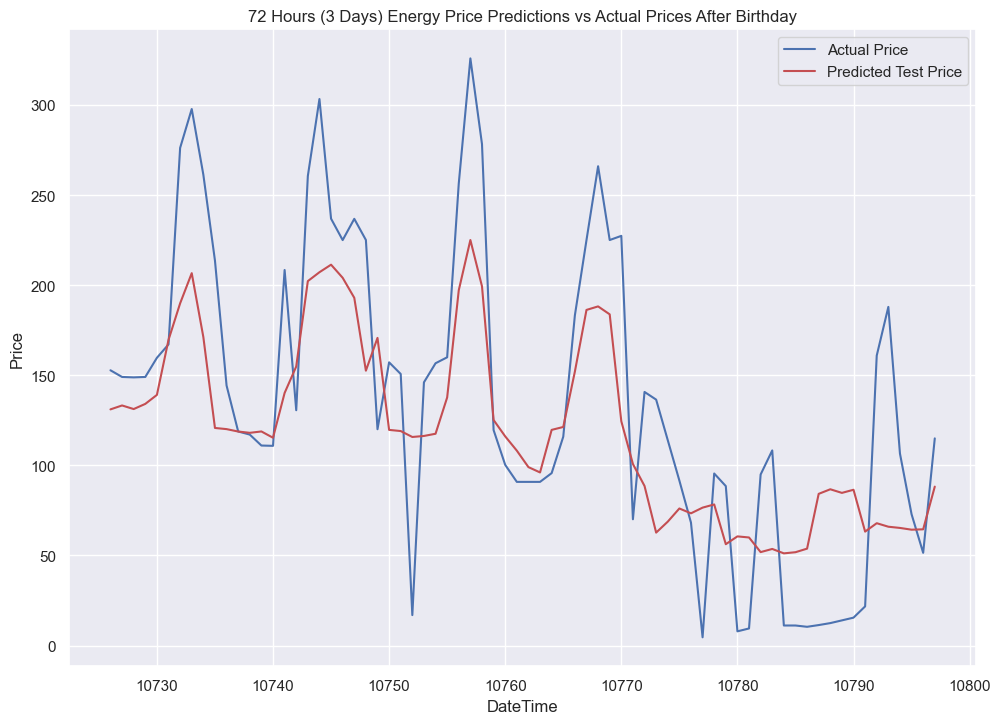

In [69]:
plt.plot(X_test.index, y_test, 'b', label='Actual Price')
plt.plot(X_test.index, search.predict(X_test), 'r', label='Predicted Test Price')
plt.title('72 Hours (3 Days) Energy Price Predictions vs Actual Prices After Birthday')
plt.xlabel('DateTime')
plt.ylabel('Price')
plt.legend()
plt.show()

Technically, this model is worse than the anecdotal one, I presented first, the error is higher, and instead of 9 euros error, I failed at 40 euros!

Nevertheless, Model 2 is methodologically more solid: it has more data (17 000 observations vs. 700 observations for daily data), does not have redundancy in variables, is more plausible in real production case, standardized and uses cross-validation. Plus, the Model 2 does not react to all the spikes in the price fluctuation due to the high-use hours.

The main issue is performance speed because the model took me 10 minutes to compute on my MacBook Pro M1. Maybe the performance could be improved if I ran it on the Kaggle servers with acceleration, but I did not try it.

Frankly speaking, here I showed all the ML skills I obtained over the last six months. Obviously, I can perform additional feature engineering by adding the price for Estonian electricity with a higher lag to capture some sort of weekly seasonality, or I can include Baltic countries' prices with a lag, as well as add more external data (inflation, market situation, any crises, etc.). Also, I could try out other predictive models (Decision Trees, Gradient Boosting), but I am confident that they would perform at the same level. Or, as a last resort, I could refer to the bagging with the best-performing models!